# HW1 布尔查询之BSBI与索引压缩

本次作业使用斯坦福大学[CS 276 / LING 286: Information Retrieval and Web Search](https://web.stanford.edu/class/cs276/)课程的代码框架来实现。具体来说主要包含的内容有：
1. [索引构建 (40%)](#索引构建与检索-(40%)) 使用BSBI方法模拟在内存不足的情况下的索引构建方式，并应用于布尔查询
2. [索引压缩 (30%)](#索引压缩-(30%)) 使用可变长编码对构建的索引进行压缩
3. [布尔检索 (10%)](#布尔联合检索-(10%)) 对空格分隔的单词查询进行联合（与）布尔检索
3. [实验报告 (10%)](#Report-(25%)) 描述你的代码并回答一些问题
4. [额外的编码方式 (10%)](#额外的编码方式-(10%)) 鼓励使用额外的编码方式对索引进行压缩 (例如, gamma-encoding)

In [1]:
# You can add additional imports here
import sys
import pickle as pkl
import array
import os
import timeit
import contextlib

# 数据集

实验使用的文本数据是stanford.edu域下的网页内容，可从http://web.stanford.edu/class/cs276/pa/pa1-data.zip 下载。以下代码将大约170MB的文本数据下载到当前目录下，

In [1]:
import urllib.request
import zipfile

data_url = 'http://web.stanford.edu/class/cs276/pa/pa1-data.zip'
data_dir = 'pa1-data'
urllib.request.urlretrieve(data_url, data_dir+'.zip')
zip_ref = zipfile.ZipFile(data_dir+'.zip', 'r')
zip_ref.extractall()
zip_ref.close()

之后构建的索引会被存储到`output_dir`，`tmp`会存储测试数据（toy-data）所生成的一些临时文件

In [19]:
try: 
    os.mkdir('output_dir')
except FileExistsError:
    pass
try: 
    os.mkdir('tmp')
except FileExistsError:
    pass
try: 
    os.mkdir('toy_output_dir')
except FileExistsError:
    pass

在数据目录下有10个子目录（命名0-9）

In [4]:
sorted(os.listdir('pa1-data'))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

每一个子目录下的文件都包含一个独立网页的内容。可以认为在同一子目录下没有同名文件，即每个文件的绝对路径不会相同。

In [5]:
sorted(os.listdir('pa1-data/0'))[:10]

['3dradiology.stanford.edu_',
 '3dradiology.stanford.edu_patient_care_Case%2520studies_AVM.html',
 '3dradiology.stanford.edu_patient_care_case_studies.html',
 '5-sure.stanford.edu_',
 '50years.stanford.edu_',
 'a3cservices.stanford.edu_awards_nominate_',
 'a3cservices.stanford.edu_facilities_',
 'a3cservices.stanford.edu_lead_',
 'aa.stanford.edu_',
 'aa.stanford.edu_about_aviation.php']

所有的网页内容已经经过处理，仅包含由空格分隔开的单词，不再需要进行额外的标准化工作。

In [6]:
with open('pa1-data/0/3dradiology.stanford.edu_', 'r') as f:
    print(f.read())

3d radiology lab stanford university school of medicine stanford school of medicine 3d and quantitative imaging in the department of radiology search this site only stanford medical sites ways to give find a person alumni lane library ways to give find a person about us mission to develop and apply innovative techniques for efficient quantitative analysis and display of medical imaging data through interdisciplinary collaboration goals education to train physicians and technologists locally and worldwide in the latest developments in 3d and quantitative imaging research to develop new approaches to the exploration analysis and quantitative assesment of diagnostic images that result in a new and or more cost effective diagnostic approaches and b new techniques for the design and planning and monitoring of therapy patient care to deliver valid clinically relevant visualization and analysis of medical imaging data to the stanford community locations richard m lucas magnetic resonance imag

# 报告的注意事项

这是一份关于BSBI的实验报告，以下是对本报告内容的一些格式的简介。

下文中在每一个大标题处进行此模块的总体报告。

同时在具体的解决以及笔记部分会在`My notes：`后标注。

代码部分也会做出相应的说明。

In [2]:
toy_dir = 'toy-data'

# 索引构建与检索 (40%)

作业的第一部分是使用**blocked sort-based indexing (BSBI)** 算法来构建倒排索引并实现布尔检索。关于BSBI算法可以参考老师课件或者斯坦福教材[Section 4.2](http://nlp.stanford.edu/IR-book/pdf/04const.pdf)。以下摘自教材内容

> To construct an index, we first make a pass through the collection assembling all term-docID pairs. We then sort the pairs with the term as the dominant key and docID as the secondary key. Finally, we organize the docIDs for each term into a postings list and compute statistics like term and document frequency. For small collections, all this can be done in memory. 

对于无法在内存一次性处理的较大数据集，将会使用到二级存储（如：磁盘）。

# 报告

在索引构建与检索模块，完成了IdMap、UncompressedPostings、InvertedIndex、BSBIIndex、InvertedIndexWriter、InvertedIndexIterator、InvertedIndexMapper、sorted_intersect的构建与实现。

`IdMap`: 实现了对文档id的映射，将文档id映射为整数，并将文档id与整数的映射存储在内存中。

`UncompressedPostings`: 实现了对倒排索引的编码，将词项及其对应的文档id列表编码为字节数组。

`InvertedIndex`: 实现了倒排索引的构建。   

`BSBIIndex`: 实现了BSBI算法。补全了函数`parse_block`, `invert_write` 和 `merge`。

`parse_block`功能是将一个分块目录中的已分词的文本文件转换为 termID-docID 对的列表。termID 是词汇项的唯一标识符，docID 是文档的唯一标识符。

`invert_write` 功能是将给定的termID-docID对列表（td_pairs）转换为倒排表，并将这些倒排表写入到指定的索引（index）中。

`merge` 功能是将多个倒排索引合并成一个单一的倒排索引，其中会用到InvertedIndexIterator来表示每一个倒排索引。


`InvertedIndexWriter`: 实现了倒排索引的写入，将倒排索引写入磁盘文件。

`InvertedIndexIterator`: 实现了倒排索引的读取，读取倒排索引文件。

`InvertedIndexMapper`: 它能够找到对应terms在索引文件中位置并取出它的倒排记录表。即可以使用key值来找到对应的文档Id列表。

`sorted_intersect`: 实现了两个倒排索引的交集。  



## IdMap (6%)

再次引用教材 Section 4.2:

> To make index construction more efficient, we represent terms as termIDs (instead of strings), where each termID is a unique serial number. We can build the mapping from terms to termIDs on the fly while we are processing the collection. Similarly, we also represent documents as docIDs (instead of strings).

我们首先定义一个辅助类`IdMap`，用于将字符串和数字ID进行相互映射，以满足我们在term和termID、doc和docID间转换的需求。

实现以下代码中的`_get_str` 和 `_get_id`函数，IdMap类的唯一接口是`__getitem__`，它是一个特殊函数，重写了下标运算`[]`,根据下标运算键的类型得到正确的映射值（如果不存在需要添加）。（特殊函数可参考[官方文档](https://docs.python.org/3.7/reference/datamodel.html#special-method-names)）
<br>
<br>
我们会用到字典来将字符串转换为数字，用列表来将数字转换为字符串。(4%)

In [3]:
class IdMap:
    """Helper class to store a mapping from strings to ids."""
    def __init__(self):
        self.str_to_id = {}
        self.id_to_str = []
        
    def __len__(self):
        """Return number of terms stored in the IdMap"""
        return len(self.id_to_str)
        
    def _get_str(self, i):
        """Returns the string corresponding to a given id (`i`)."""
        ### Begin your code
        if(0<=i<len(self.id_to_str)):
            return self.id_to_str[i]
        #需要考虑i超出范围的情况
        else:
            raise IndexError("Index out of range")
        ### End your code
        
    def _get_id(self, s):
        """Returns the id corresponding to a string (`s`). 
        If `s` is not in the IdMap yet, then assigns a new id and returns the new id.
        """
        ### Begin your code
        if(s in self.str_to_id):
            return self.str_to_id[s]
        else:
            self.str_to_id[s] = len(self.id_to_str)
            self.id_to_str.append(s)
            #这里需要-1，因为append（s）后列表长度有了变化     
            return len(self.id_to_str)-1
        ### End your code
            
    def __getitem__(self, key):
        """If `key` is a integer, use _get_str; 
           If `key` is a string, use _get_id;"""
        if type(key) is int:
            return self._get_str(key)
        elif type(key) is str:
            return self._get_id(key)
        else:
            raise TypeError

确保代码能通过以下简单测试样例 (2%)

In [4]:
testIdMap = IdMap()
assert testIdMap['a'] == 0, "Unable to add a new string to the IdMap"
assert testIdMap['bcd'] == 1, "Unable to add a new string to the IdMap"
assert testIdMap['a'] == 0, "Unable to retrieve the id of an existing string"
assert testIdMap[1] == 'bcd', "Unable to retrive the string corresponding to a\
                                given id"
try:
    testIdMap[2]
except IndexError as e:
    assert True, "Doesn't throw an IndexError for out of range numeric ids"
assert len(testIdMap) == 2

之后会需要你自己来写测试样例来确保你的程序正常运行

## 将倒排列表编码成字节数组 (2%)

为了高效地从磁盘读写倒排列表（文档ID），我们将其存储为字节数组的形式。代码提供了`UncompressedPostings`类来用静态函数实现对倒排列表的编码和解码。在之后的任务中你需要使用该接口实现索引压缩版本（可变长编码）。

参考:
1. https://docs.python.org/3/library/array.html
2. https://pymotw.com/3/array/#module-array

In [5]:
class UncompressedPostings:
    
    @staticmethod
    def encode(postings_list):
        """Encodes postings_list into a stream of bytes
        
        Parameters
        ----------
        postings_list: List[int]
            List of docIDs (postings)
            
        Returns
        -------
        bytes
            bytearray representing integers in the postings_list
        """
        return array.array('L', postings_list).tobytes()
        
    @staticmethod
    def decode(encoded_postings_list):
        """Decodes postings_list from a stream of bytes
        
        Parameters
        ----------
        encoded_postings_list: bytes
            bytearray representing encoded postings list as output by encode 
            function
            
        Returns
        -------
        List[int]
            Decoded list of docIDs from encoded_postings_list
        """
        
        decoded_postings_list = array.array('L')
        decoded_postings_list.frombytes(encoded_postings_list)
        return decoded_postings_list.tolist()

运行以下代码查看其工作方式 (2%)

In [6]:
x = UncompressedPostings.encode([1,2,3])
print(x)
print(UncompressedPostings.decode(x))

b'\x01\x00\x00\x00\x02\x00\x00\x00\x03\x00\x00\x00'
[1, 2, 3]


# My Notes：

运行以上代码,解释工作方式:

首先调用编码得到b'\x01\x00\x00\x00\x02\x00\x00\x00\x03\x00\x00\x00'，然后解码得到[1, 2, 3]。

经查询得到:

(1)在 Python 的字节串(bytes 对象)表示中，\x01 是一种十六进制转义序列，用于表示一个字节的数据。

(2)在 Python 里，字节串以 b 开头，用于表示一系列的字节数据。
              
则每一个整数被编码为4个字节,并且是无符号的长整型。

## 磁盘上的倒排索引 (2%)

> With main memory insufficient, we need to use an external sorting algorithm, that is, one that uses disk. For acceptable speed, the central requirement of such an algorithm is that it minimize the number of random disk seeks during sorting - sequential disk reads are far faster than seeks. 

在这一部分我们提供了一个基类`InvertedIndex`，之后会在此基础上构建它的子类`InvertedIndexWriter`, `InvertedIndexIterator` 和 `InvertedIndexMapper`。在Python中我们常用`cPickle`进行序列化，但是它并不支持部分读和部分写，无法满足BSBI算法的需要，所以我们需要定义自己的存储方式。

In [7]:
class InvertedIndex:
    """A class that implements efficient reads and writes of an inverted index 
    to disk
    
    Attributes
    ----------
    postings_dict: Dictionary mapping: termID->(start_position_in_index_file, 
                                                number_of_postings_in_list,
                                               length_in_bytes_of_postings_list)
        This is a dictionary that maps from termIDs to a 3-tuple of metadata 
        that is helpful in reading and writing the postings in the index file 
        to/from disk. This mapping is supposed to be kept in memory. 
        start_position_in_index_file is the position (in bytes) of the postings 
        list in the index file
        number_of_postings_in_list is the number of postings (docIDs) in the 
        postings list
        length_in_bytes_of_postings_list is the length of the byte 
        encoding of the postings list
    
    terms: List[int]
        A list of termIDs to remember the order in which terms and their 
        postings lists were added to index. 
        
        After Python 3.7 we technically no longer need it because a Python dict 
        is an OrderedDict, but since it is a relatively new feature, we still
        maintain backward compatibility with a list to keep track of order of 
        insertion. 
    """
    def __init__(self, index_name, postings_encoding=None, directory=''):
        """
        Parameters
        ----------
        index_name (str): Name used to store files related to the index
        postings_encoding: A class implementing static methods for encoding and 
            decoding lists of integers. Default is None, which gets replaced
            with UncompressedPostings
        directory (str): Directory where the index files will be stored
        """

        self.index_file_path = os.path.join(directory, index_name+'.index')
        self.metadata_file_path = os.path.join(directory, index_name+'.dict')

        if postings_encoding is None:
            self.postings_encoding = UncompressedPostings
        else:
            self.postings_encoding = postings_encoding
        self.directory = directory

        self.postings_dict = {}
        self.terms = []         #Need to keep track of the order in which the 
                                #terms were inserted. Would be unnecessary 
                                #from Python 3.7 onwards

    def __enter__(self):
        """Opens the index_file and loads metadata upon entering the context"""
        # Open the index file
        self.index_file = open(self.index_file_path, 'rb+')

        # Load the postings dict and terms from the metadata file
        with open(self.metadata_file_path, 'rb') as f:
            self.postings_dict, self.terms = pkl.load(f)
            self.term_iter = self.terms.__iter__()                       

        return self
    
    def __exit__(self, exception_type, exception_value, traceback):
        """Closes the index_file and saves metadata upon exiting the context"""
        # Close the index file
        self.index_file.close()
        
        # Write the postings dict and terms to the metadata file
        with open(self.metadata_file_path, 'wb') as f:
            pkl.dump([self.postings_dict, self.terms], f)

因为是在与磁盘上的文件进行交互，所以我们提供了`__enter__`和`__exit__`函数，它使得我们能够像使用python中文件IO一样使用`with`语句。（参考[上下文管理器官方文档](https://docs.python.org/3/library/contextlib.html)）

以下是使用 `InvertedIndexWriter` 上下文管理器的实例: (2%)

```python
with InvertedIndexWriter('test', directory='tmp/') as index:
    # Some code here
```

## 索引 (30%)

> BSBI (i) segments the collection into parts of equal size, (ii) sorts the termID-docID pairs of each part in memory, (iii) stores intermediate sorted results on disk, and (iv) merges all intermediate results into the final index. 

你需要将每一个子目录当做一个块（block），并且在构建索引的过程中每次只能加载一个块（模拟内存不足）。注意到我们是将操作系统意义上的块进行了抽象。你可以认为每个块足够小，能被装载进内存。

在这一部分，我们将阶段性地构造类`BSBIIndex`。函数`index`给出了BSBI算法的框架，而你的工作则是在接下来的部分中实现函数`parse_block`, `invert_write` 和 `merge`。

In [8]:
# Do not make any changes here, they will be overwritten while grading
class BSBIIndex:
    """ 
    Attributes
    ----------
    term_id_map(IdMap): For mapping terms to termIDs
    doc_id_map(IdMap): For mapping relative paths of documents (eg 
        0/3dradiology.stanford.edu_) to docIDs
    data_dir(str): Path to data
    output_dir(str): Path to output index files
    index_name(str): Name assigned to index
    postings_encoding: Encoding used for storing the postings.
        The default (None) implies UncompressedPostings
    """
    def __init__(self, data_dir, output_dir, index_name = "BSBI", 
                 postings_encoding = None):
        self.term_id_map = IdMap()
        self.doc_id_map = IdMap()
        self.data_dir = data_dir
        self.output_dir = output_dir
        self.index_name = index_name
        self.postings_encoding = postings_encoding

        # Stores names of intermediate indices
        self.intermediate_indices = []
        
    def save(self):
        """Dumps doc_id_map and term_id_map into output directory"""
        
        with open(os.path.join(self.output_dir, 'terms.dict'), 'wb') as f:
            pkl.dump(self.term_id_map, f)
        with open(os.path.join(self.output_dir, 'docs.dict'), 'wb') as f:
            pkl.dump(self.doc_id_map, f)
    
    def load(self):
        """Loads doc_id_map and term_id_map from output directory"""
        
        with open(os.path.join(self.output_dir, 'terms.dict'), 'rb') as f:
            self.term_id_map = pkl.load(f)
        with open(os.path.join(self.output_dir, 'docs.dict'), 'rb') as f:
            self.doc_id_map = pkl.load(f)
            
    def index(self):
        """Base indexing code
        
        This function loops through the data directories, 
        calls parse_block to parse the documents
        calls invert_write, which inverts each block and writes to a new index
        then saves the id maps and calls merge on the intermediate indices
        """
        for block_dir_relative in sorted(next(os.walk(self.data_dir))[1]):
            td_pairs = self.parse_block(block_dir_relative)
            index_id = 'index_'+block_dir_relative
            self.intermediate_indices.append(index_id)
            with InvertedIndexWriter(index_id, directory=self.output_dir, 
                                     postings_encoding=
                                     self.postings_encoding) as index:
                self.invert_write(td_pairs, index)
                td_pairs = None
        self.save()
        with InvertedIndexWriter(self.index_name, directory=self.output_dir, 
                                 postings_encoding=
                                 self.postings_encoding) as merged_index:
            with contextlib.ExitStack() as stack:
                indices = [stack.enter_context(
                    InvertedIndexIterator(index_id, 
                                          directory=self.output_dir, 
                                          postings_encoding=
                                          self.postings_encoding)) 
                 for index_id in self.intermediate_indices]
                self.merge(indices, merged_index)

### 解析 (10%)

> The function `parse_block`  parses documents into termID-docID pairs and accumulates the pairs in memory until a block of a fixed size is full. We choose the block size to fit comfortably into memory to permit a fast in-memory sort. 

你需要将每一个子目录当做一个块，`parse_block`接收子目录路径作为参数。同一子目录下所有文件名都是不同的。 (5%)

_注意 - 我们使用 `BSBIIndex` 继承 `BSBIIndex`, 这只是对一个已存在类添加新内容的简单方法。在这里只是用来切分类的定义（jupyter notebook内教学使用，无特殊含义）。_

In [9]:
class BSBIIndex(BSBIIndex):            
    def parse_block(self, block_dir_relative):
        """Parses a tokenized text file into termID-docID pairs
        
        Parameters
        ----------
        block_dir_relative : str
            Relative Path to the directory that contains the files for the block
        
        Returns
        -------
        List[Tuple[Int, Int]]
            Returns all the td_pairs extracted from the block
        
        Should use self.term_id_map and self.doc_id_map to get termIDs and docIDs.
        These persist across calls to parse_block
        """
        ### Begin your code

        td_pairs = []
        block_dir = os.path.join(self.data_dir,block_dir_relative)  # block_dir为block_dir_relative的绝对路径
        for file in sorted(os.listdir(block_dir)):  # 遍历block_dir中的文件
            with open(os.path.join(block_dir,file),'r') as f:# 打开文件
                for line in f:
                    words = line.strip().split()
                    for word in words:
                        term_id = self.term_id_map[word.strip()]    # 获取term_id
                        doc_id = self.doc_id_map[os.path.join(block_dir_relative,file)] # 获取doc_id
                        td_pairs.append((term_id,doc_id))   # 将(term_id,doc_id)添加到td_pairs
        return td_pairs
      
        ### End your code

观察函数在测试数据上是否正常运行 (2%)

In [10]:
with open('toy-data/0/fine.txt', 'r') as f:
    print(f.read())
with open('toy-data/0/hello.txt', 'r') as f:
    print(f.read())

i'm fine , thank you

hi hi
how are you ?



In [11]:
BSBI_instance = BSBIIndex(data_dir=toy_dir, output_dir = 'tmp/', index_name = 'toy')
BSBI_instance.parse_block('0')

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (4, 1),
 (8, 1)]

My nodes：

由于这里只对空格进行了分割，但是在fine.txt和hello.text文件中存在,'?三个符号。会在处理时把i'm当作一个词。当把，改成空格配对个数会加一。 

写一些测试样例来确保`parse_block`方法正常运行（如：相同单词出现时是相同ID） (3%)

In [12]:
### Begin your code

with open('toy-data/1/bye.txt', 'r') as f:
    print(f.read())
with open('toy-data/1/byebye.txt', 'r') as f:
    print(f.read())

test_instance = BSBIIndex(toy_dir, output_dir = 'tmp/', index_name = 'toy')
test_instance.term_id_map = {'good':0,'to':1,'see':2,'you':3,',':4,'bye':5,'later':6,'?':7}
test_instance.doc_id_map = {'1\\bye.txt':0,'1\\byebye.txt':1}
test_instance.parse_block('1')
assert test_instance.term_id_map == test_instance.term_id_map ==  {'good':0,'to':1,'see':2,'you':3,',':4,'bye':5,'later':6,'?':7},'term_id_map error'
assert test_instance.doc_id_map == {'1\\bye.txt':0,'1\\byebye.txt':1},'doc_id_map error'

### End your code

good to see you , bye
see you later ?

bye
bye
bye



### 倒排表 (10%)

> The block is then inverted and written to disk. Inversion involves two steps. First, we sort the termID-docID pairs. Next, we collect all termID-docID pairs with the same termID into a postings list, where a posting is simply a docID. The result, an inverted index for the block we have just read, is then written to disk.

在这一部分我们添加函数`invert_write`来实现由termID-docID对构建倒排表。 

但是，我们首先需要实现类`InvertedIndexWriter`。和列表类似，该类提供了append函数，但是倒排表不会存储在内存中而是直接写入到磁盘里。 (3%)

In [13]:
class InvertedIndexWriter(InvertedIndex):
    """"""
    def __enter__(self):
        self.index_file = open(self.index_file_path, 'wb+')              
        return self

    def append(self, term, postings_list):
        """Appends the term and postings_list to end of the index file.
        
        This function does three things, 
        1. Encodes the postings_list using self.postings_encoding
        2. Stores metadata in the form of self.terms and self.postings_dict
           Note that self.postings_dict maps termID to a 3 tuple of 
           (start_position_in_index_file, 
           number_of_postings_in_list, 
           length_in_bytes_of_postings_list)
        3. Appends the bytestream to the index file on disk

        Hint: You might find it helpful to read the Python I/O docs
        (https://docs.python.org/3/tutorial/inputoutput.html) for
        information about appending to the end of a file.
        
        Parameters
        ----------
        term:
            term or termID is the unique identifier for the term
        postings_list: List[Int]
            List of docIDs where the term appears
        """
        ### Begin your code

        encoded_list = self.postings_encoding.encode(postings_list) # 将postings_list转换为bytes类型

        self.terms.append(term)
        start_position_in_index_file = self.index_file.tell()
        number_of_postings_in_list = len(postings_list)
        length_in_bytes_of_postings_list = len(encoded_list)
        self.postings_dict.update({term:(start_position_in_index_file,  number_of_postings_in_list, length_in_bytes_of_postings_list)}) # 将元数据存储到postings_dict中

        self.index_file.write(encoded_list) # 将encoded_list写入文件

        ### End your code

尽管还没有实现读取索引的类，我们还是可以用以下测试代码检测我们的实现。 (2%)

In [20]:
with InvertedIndexWriter('test', directory='tmp/') as index:
    index.append(1, [2, 3, 4])
    index.append(2, [3, 4, 5])
    index.index_file.seek(0)
    assert index.terms == [1,2], "terms sequence incorrect"
    assert index.postings_dict == {1: (0, 3, len(UncompressedPostings.encode([2,3,4]))), 
                                   2: (len(UncompressedPostings.encode([2,3,4])), 3, 
                                       len(UncompressedPostings.encode([3,4,5])))}, "postings_dict incorrect"
    assert UncompressedPostings.decode(index.index_file.read()) == [2, 3, 4, 3, 4, 5], "postings on disk incorrect"

现在我们实现 `invert_write`，它将解析得到的td_pairs转换成倒排表，并使用`InvertedIndexWriter` 类将其写入磁盘。 (3%)

In [18]:
class BSBIIndex(BSBIIndex):
    def invert_write(self, td_pairs, index):
        """Inverts td_pairs into postings_lists and writes them to the given index
        
        Parameters
        ----------
        td_pairs: List[Tuple[Int, Int]]
            List of termID-docID pairs
        index: InvertedIndexWriter
            Inverted index on disk corresponding to the block       
        """
        ### Begin your code

        td_pairs = sorted(td_pairs,key=lambda x:(x[0],x[1]))#排序
        term_id_pre = ''#上一个词项
        doc_id_pre = ''#上一个文档项
        postings_list = []
        for term_id,doc_id in td_pairs: 
            if term_id == term_id_pre: #还在构建同一个倒排表中
                if doc_id != doc_id_pre: 
                    postings_list.append(doc_id)
                    doc_id_pre = doc_id
            else: #完成一个词项的倒排表
                if term_id_pre!='':
                    index.append(term_id_pre,postings_list)
                    postings_list = [doc_id]
                    doc_id_pre = doc_id 
                    term_id_pre = term_id
                else:#初始情况
                    postings_list = [doc_id]
                    doc_id_pre = doc_id 
                    term_id_pre = term_id
                    
        #最后一个词项的倒排表
        index.append(term_id_pre,postings_list)

        ### End your code

# My notes：

对处理最后一项的解释：由于每一次都是将（上一个term_id，上一个词项的倒排表）添加进入index。但是最后一个（term_id，词项的倒排表）只经历了if语句的构造过程，没有经历else里面的index.append()操作，所以需要单独添加。

我们可以在测试数据上读取一个块并观察倒排索引中包含的内容。
仿照`InvertedIndexWriter`部分写一些测试样例。 (2%)

# My notes:

这里的td_pairs和仿照代码的数据经过invert_write()函数处理后，得到的倒排索引是一致的。进行测试。

In [21]:
### Begin your code

with InvertedIndexWriter('test', directory='tmp/') as index:
    
    td_pairs = [(2,3),(2,4),(2,5),(1,2),(1,3),(1,4)]
    test_instance = BSBIIndex('',output_dir='tmp/')
    test_instance.invert_write(td_pairs,index)
    index.index_file.seek(0)
    assert index.terms == [1,2], "terms sequence incorrect"
    assert index.postings_dict == {1: (0, 3, len(UncompressedPostings.encode([2,3,4]))), 
                                   2: (len(UncompressedPostings.encode([2,3,4])), 3, 
                                       len(UncompressedPostings.encode([3,4,5])))}, "postings_dict incorrect"
    assert UncompressedPostings.decode(index.index_file.read()) == [2, 3, 4, 3, 4, 5], "postings on disk incorrect"

### End your code

### 合并 (10%)
> The algorithm simultaneously merges the ten blocks into one large merged index. To do the merging, we open all block files simultaneously, and maintain small read buffers for the ten blocks we are reading and a write buffer for the final merged index we are writing. 

Python中的迭代模型非常自然地符合我们维护一个小的读缓存的要求。我们可以迭代地从磁盘上每次读取文件的一个倒排列表。我们通过构建`InvertedIndex`的子类`InvertedIndexIterator`来完成这个迭代任务。 (3%)

In [22]:
class InvertedIndexIterator(InvertedIndex):
    """"""
    def __enter__(self):
        """Adds an initialization_hook to the __enter__ function of super class
        """
        super().__enter__()
        self._initialization_hook()
        return self

    def _initialization_hook(self):
        """Use this function to initialize the iterator
        """
        ### Begin your code
        
        
        self.current = 0 # 记录当前读取的是第几个term
        self.num = len(self.terms) # 记录总共有多少个term

        ### End your code

    def __iter__(self): 
        return self      #__iter__ 方法返回了自身（self）。这意味着 InvertedIndexIterator 类的实例本身就是一个迭代器。
    
    def __next__(self):#定义迭代的逻辑和返回的值。
        """Returns the next (term, postings_list) pair in the index.
        
        Note: This function should only read a small amount of data from the 
        index file. In particular, you should not try to maintain the full 
        index file in memory.
        """
        ### Begin your code

        if self.current < self.num:
            term = next(self.term_iter)
            start_position_in_index_file,number_of_postings_in_list,length_in_bytes_of_postings_list = self.postings_dict[term]
            
            # file.seek(offset, whence)
            # 其中，offset 是要移动的字节数，而 whence 是一个可选参数，用于指定从哪个位置开始移动文件指针。
            # whence 参数可以接受三个不同的值：
            # 0 或 os.SEEK_SET：从文件的开始位置（即文件的开头）开始移动。这是 whence 的默认值。
            # 1 或 os.SEEK_CUR：从当前文件指针的位置开始移动。
            # 2 或 os.SEEK_END：从文件的末尾开始移动。
            
            self.index_file.seek(0,1) 
            post_binary = self.index_file.read(length_in_bytes_of_postings_list)
            postings_list = self.postings_encoding.decode(post_binary)
            self.current += 1
            return (term,postings_list)
        else:
            raise StopIteration
        
        ### End your code

    def delete_from_disk(self):
        """Marks the index for deletion upon exit. Useful for temporary indices
        """
        self.delete_upon_exit = True

    def __exit__(self, exception_type, exception_value, traceback):
        """Delete the index file upon exiting the context along with the
        functions of the super class __exit__ function"""
        self.index_file.close()
        if hasattr(self, 'delete_upon_exit') and self.delete_upon_exit:
            os.remove(self.index_file_path)
            os.remove(self.metadata_file_path)
        else:
            with open(self.metadata_file_path, 'wb') as f:
                pkl.dump([self.postings_dict, self.terms], f)

为了测试以上代码，我们先用`InvertedIndexWriter` 创建索引，然后再迭代遍历。写一些小的测试样例观察它是否正常运行。至少你得写一个测试，手工构建一个小的索引，用`InvertedIndexWriter`将他们写入磁盘，然后用`InvertedIndexIterator`迭代遍历倒排索引。 (2%)

In [23]:
### Begin your code

with InvertedIndexWriter('test', directory='tmp/') as index:
    td_pairs = [(2,3),(2,4),(2,5),(1,2),(1,3),(1,4)]
    test_instance = BSBIIndex('test',output_dir='tmp/',index_name='toy')
    test_instance.invert_write(td_pairs,index)

with InvertedIndexIterator('test',directory='tmp/') as index_iter:
    for idx, td_pair in enumerate(index_iter):
        if idx == 0:
            assert td_pair == (1,[2,3,4]),'第一个term的postings_list错误'
        if idx == 1:
            assert td_pair == (2,[3,4,5]),'第二个term的postings_list错误'

### End your code

> During merging, in each iteration, we select the lowest termID that has not been processed yet using a priority queue or a similar data structure. All postings lists for this termID are read and merged, and the merged list is written back to disk. Each read buffer is refilled from its file when necessary.

我们将使用`InvertedIndexIterator`来完成读取的部分，用`InvertedIndexWriter`来将合并后的索引写入磁盘。

注意到我们之前一直使用`with` 语句来打开倒排索引文件，但是现在需要程序化地完成这项工作。可以看到我们在基类`BSBIIndex`的`index`函数中使用了`contextlib`([参考文档](https://docs.python.org/3/library/contextlib.html#contextlib.ExitStack))
你的任务是合并*打开的*`InvertedIndexIterator`对象（倒排列表），并且通过一个`InvertedIndexWriter`对象每次写入一个文档列表。

既然我们知道文档列表已经排过序了，那么我们可以在线性时间内对它们进行合并排序。事实上`heapq`([参考文档](https://docs.python.org/3.0/library/heapq.html)) 是Python中一个实现了堆排序算法的标准模板。另外它还包含一个实用的函数`heapq.merge`，可以将多个已排好序的输入（可迭代）合并成一个有序的输出并返回它的迭代器。它不仅可以用来合并倒排列表，也可以合并倒排索引词典。

为了让你快速上手`heapq.merge`函数，我们提供了一个简单的使用样例。给出两个以动物和树平均寿命排序的列表，我们希望合并它们。

In [24]:
import heapq
animal_lifespans = [('Giraffe', 28), 
                   ('Rhinoceros', 40), 
                   ('Indian Elephant', 70), 
                   ('Golden Eagle', 80), 
                   ('Box turtle', 123)]

tree_lifespans = [('Gray Birch', 50), 
                  ('Black Willow', 70), 
                  ('Basswood', 100),
                  ('Bald Cypress', 600)]

lifespan_lists = [animal_lifespans, tree_lifespans]

for merged_item in heapq.merge(*lifespan_lists, key=lambda x: x[1]):
    print(merged_item)

('Giraffe', 28)
('Rhinoceros', 40)
('Gray Birch', 50)
('Indian Elephant', 70)
('Black Willow', 70)
('Golden Eagle', 80)
('Basswood', 100)
('Box turtle', 123)
('Bald Cypress', 600)


# My notes：

将x[1]改为x[0]时，名字并没有完全按照字典序进行排列。

('Giraffe', 28)
('Gray Birch', 50)
('Black Willow', 70)
('Basswood', 100)
('Bald Cypress', 600)
('Rhinoceros', 40)
('Indian Elephant', 70)
('Golden Eagle', 80)
('Box turtle', 123)

原因是由于animal_lifespans和tree_lifespans中的名字是没有进行字典序排序的，而heapq.merge()是需要每一个输入的序列都已经按照相同的方式排好序。

注意使用`*`将`lifespan_lists`解包作为参数，并且使用`lambda`函数来给出进行排序的key。如果你对它们不熟悉可以参考文档([unpacking lists](https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists), [lambda expressions](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions))。 (3%)

In [25]:
import heapq
class BSBIIndex(BSBIIndex):
    def merge(self, indices, merged_index):
        """Merges multiple inverted indices into a single index
        
        Parameters
        ----------
        indices: List[InvertedIndexIterator]
            A list of InvertedIndexIterator objects, each representing an
            iterable inverted index for a block
        merged_index: InvertedIndexWriter
            An instance of InvertedIndexWriter object into which each merged 
            postings list is written out one at a time
        """
        ### Begin your code

     

        merged_postings_lists = list(heapq.merge(*indices, key=lambda x: x[0]))
        term_id_pre = ''
        postings_list = []
        
        with merged_index:
            for term_id,doc_list in merged_postings_lists:
                if term_id == term_id_pre:
                    #相同的term,将两个表合并
                    postings_list.append(doc_list)

                else: #已经完成一个链表，要存起来了
                    if term_id_pre != '':

                        temp_postings = []
                        # 合并文档列表；这里需要去重，因为会有重复的doc_id
                        for doc_id in heapq.merge(*postings_list, key=lambda x: x):
                            if not temp_postings or doc_id != temp_postings[-1]:
                                temp_postings.append(doc_id)
                        merged_postings_list = temp_postings
                        merged_index.append(term_id_pre, merged_postings_list)# 将上一个term的postings_list写入文件

                        #不去重代码
                        # merged_postings_list = list(heapq.merge(*postings_list, key=lambda x: x))
                        # merged_index.append(term_id_pre,merged_postings_list) 
                        
                        term_id_pre = term_id
                        postings_list.clear()
                        postings_list.append(doc_list)
                        
                    else:#初始情况
                        term_id_pre = term_id
                        postings_list.append(doc_list)

            #处理最后一项
            merged_postings_list =  list(set(heapq.merge(*postings_list, key=lambda x: x))) 
            merged_index.append(term_id_pre,merged_postings_list) 

        ### End your code

# My notes：

*postings_list: * 操作符在这里用于解包 postings_list 中的元素。

假设 postings_list 是一个包含多个文档列表的列表，例如 [[doc1, doc2], [doc3, doc4], ...]，那么 *postings_list 将会变成 ([doc1, doc2], [doc3, doc4], ...)。

但是这种合并会有重复的情况,需要进行去重处理。通过set（）变成集合来实现。

最开始使用如下代码，


        merged_postings_lists = list(heapq.merge(*indices, key=lambda x: x[0]))
        term_id_pre = ''
        postings_list = []
        
        with merged_index:
            for term_id,doc_list in merged_postings_lists:
                if term_id == term_id_pre:
                    #相同的term,将两个表合并
                    postings_list.append(doc_list)
                else: #已经完成一个链表，要存起来了
                    if term_id_pre != '':
                        merged_postings_list = list(set(heapq.merge(*postings_list, key=lambda x: x)))# 合并文档列表；这里需要去重，因为会有重复的doc_id
                        merged_index.append(term_id_pre,merged_postings_list) # 将上一个term的postings_list写入文件
                        
                        term_id_pre = term_id
                        postings_list.clear()
                        postings_list.append(doc_list)
                        
                    else:#初始情况
                        term_id_pre = term_id
                        postings_list.append(doc_list)

            #处理最后一项
            merged_postings_list =  list(set(heapq.merge(*postings_list, key=lambda x: x))) 
            merged_index.append(term_id_pre,merged_postings_list) 

在合并阶段测试没有报错，但是在进行到布尔检索时，测试dev queries出现了错误，检索到的文档与预期不符。

在仔细查看代码后发现是因为先排序后转为了set，导致文档变成了无序状态，导致布尔检索结果不正确。

首先确保它在测试数据上正常运行

In [26]:
BSBI_instance = BSBIIndex(data_dir=toy_dir, output_dir = 'toy_output_dir', )
BSBI_instance.index()

接下来对整个数据集构建索引 (2%)

In [27]:
BSBI_instance = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir', )
BSBI_instance.index()

如果你在合并阶段出现了错误，可以利用以下代码来debug。

In [28]:
BSBI_instance = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir', )
BSBI_instance.intermediate_indices = ['index_'+str(i) for i in range(10)]
with InvertedIndexWriter(BSBI_instance.index_name, directory=BSBI_instance.output_dir, postings_encoding=BSBI_instance.postings_encoding) as merged_index:
    with contextlib.ExitStack() as stack:
        indices = [stack.enter_context(InvertedIndexIterator(index_id, directory=BSBI_instance.output_dir, postings_encoding=BSBI_instance.postings_encoding)) for index_id in BSBI_instance.intermediate_indices]
        BSBI_instance.merge(indices, merged_index)

## 布尔联合检索 (10%)

我们将实现BSBIIndex中的`retrieve`函数，对于给定的包含由空格分隔tokens的字符串查询，返回包含查询中所有tokens的文档列表。但是我们并不能迭代遍历整个索引或者将整个索引加载到内存来寻找相应的terms（索引太大）。

首先我们要实现`InvertedIndex`的子类`InvertedIndexMapper`，它能够找到对应terms在索引文件中位置并取出它的倒排记录表。 (2%)

In [29]:
class InvertedIndexMapper(InvertedIndex):
    def __getitem__(self, key):
        return self._get_postings_list(key)
    
    def _get_postings_list(self, term):
        """Gets a postings list (of docIds) for `term`.
        
        This function should not iterate through the index file.
        I.e., it should only have to read the bytes from the index file
        corresponding to the postings list for the requested term.
        """
        ### Begin your code

        start_position_in_index_file,number_of_postings_in_list,length_in_bytes_of_postings_list = self.postings_dict[term]
       
        self.index_file.seek(start_position_in_index_file)
        encoded_postings_list = self.index_file.read(length_in_bytes_of_postings_list)
        posting_list = self.postings_encoding.decode(encoded_postings_list)
        return posting_list

        ### End your code

写一些测试样例检测`_get_postings_list`的实现 (1%)

In [30]:
### Begin your code

with InvertedIndexWriter('test',directory='tmp/') as index_writer:
    index_writer.append(1,[2,3,4])
    index_writer.append(2,[3,4,5])

with InvertedIndexMapper('test',directory='tmp/') as index_mapper:
    assert index_mapper[1] == [2,3,4],'term_id为1的postings_list错误'
    assert index_mapper[2] == [3,4,5],'term_id为2的postings_list错误'

### End your code

现在我们获得了查询中terms对应的倒排记录表，接着需要求他们的交集。这部分与我们之前作业的merge方法类似，请实现`sorted_intersect`函数，遍历两个有序列表并在线性时间内合并。 (2%)

In [31]:
def sorted_intersect(list1, list2):
    """Intersects two (ascending) sorted lists and returns the sorted result
    
    Parameters
    ----------
    list1: List[Comparable]
    list2: List[Comparable]
        Sorted lists to be intersected
        
    Returns
    -------
    List[Comparable]
        Sorted intersection        
    """
    ### Begin your code

    index1 = index2 = 0
    result = []
    while index1 < len(list1) and index2 < len(list2):  
        if list1[index1] == list2[index2]: 
            result.append(list1[index1])
            index1 += 1
            index2 += 1
        elif list1[index1] < list2[index2]:
            index1 += 1
        else:
            index2 += 1
    return result

    ### End your code

# My notes:

使用了分别指向两个列表的指针，因为已经排好了序，所以只需要判断当前位置列表中的值的大小关系，相等则加入，不等则更大的列表指针跳过。

简单的测试样例 (1%)

In [32]:
### Begin your code

list1 = [1,2,3,4,5,6,7,8,9,10]
list2 = [1,3,5,7,9]
list3 = [2,4,6,8,10]
assert sorted_intersect(list1,list2) == [1,3,5,7,9], "Test case 1 failed"
assert sorted_intersect(list1,list3) == [2,4,6,8,10], "Test case 2 failed"
assert sorted_intersect(list2,list3) == [], "Test case 3 failed"

### End your code

现在可以利用`sorted_intersect` 和 `InvertedIndexMapper`来实现`retrieve`函数。 (3%)

In [33]:
# %%tee submission/retrieve.py
class BSBIIndex(BSBIIndex):
    def retrieve(self, query):
        """Retrieves the documents corresponding to the conjunctive query
        
        Parameters
        ----------
        query: str
            Space separated list of query tokens
            
        Result
        ------
        List[str]
            Sorted list of documents which contains each of the query tokens. 
            Should be empty if no documents are found.
        
        Should NOT throw errors for terms not in corpus
        """
        if len(self.term_id_map) == 0 or len(self.doc_id_map) == 0:
            self.load()

        ## Begin your code

        doc_id_result = ''#如果写成[]，一旦中间交集过程中出现了[]，就会重新进入到空值判断的if语句中，导致与预期结果不符合。
        terms = query.strip().split(' ') # 将query转换为list

        id_doc_map = self.doc_id_map.id_to_str
        for term in terms:  # 遍历terms
            term_id = self.term_id_map[term]
            with InvertedIndexMapper(self.index_name,self.postings_encoding,self.output_dir) as index_mapper: 
                if doc_id_result == '':
                    doc_id_result = index_mapper[term_id]   # 如果是第一个term，直接将doc_ids赋值为第一个term的postings_list
                else:
                    doc_id_result = sorted_intersect(doc_id_result,index_mapper[term_id]) # 两个列表求交集
        doc_list = [id_doc_map[doc_id] for doc_id in doc_id_result]
        return doc_list

        ### End your code

通过一个简单的查询来测试索引在真实数据集上是否正常工作。

In [34]:
BSBI_instance = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir', )
BSBI_instance.retrieve('boolean retrieval')

['1\\cs276.stanford.edu_',
 '1\\cs276a.stanford.edu_',
 '3\\infolab.stanford.edu_TR_CS-TN-95-21.html',
 '4\\nlp.stanford.edu_IR-book_',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_an-appraisal-of-probabilistic-models-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_bayesian-network-approaches-to-ir-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_boolean-retrieval-2.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_computing-scores-in-a-complete-search-system-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_dictionaries-and-tolerant-retrieval-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_efficient-scoring-and-ranking-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_inexact-top-k-document-retrieval-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_probabilistic-information-retrieval-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_putting-it-all-together-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_references-and-furth

你也可以通过读取文件来测试其中的页面是否真的包含了查询的terms

In [35]:
with open("pa1-data/1/cs276.stanford.edu_", 'r') as f:
    print(f.read())

cs276 information retrieval and web search cs 276 ling 286 information retrieval and web search spring 2011 pandu nayak and prabhakar raghavan lecture 3 units tu th 4 15 5 30 gates b03 tas sonali aggarwal ivan cui valentin spitkovsky and sandeep sripada staff e mail cs276 spr1011 staff lists stanford edu lectures are also available online and on television through scpd sitn course description basic and advanced techniques for text based information systems efficient text indexing boolean and vector space retrieval models evaluation and interface issues web search including crawling link based algorithms and web metadata text web clustering classification text mining syllabus additional information staff contact information piazzza we strongly recommend students to post questions to the course page on www piazzza com instead of sending emails this forum enables students to discuss the questions they encounter in lectures or assignments here is a quick introduction video email if you hav

测试dev queries（提前构建好的查询与结果）是否正确 (1%)

In [36]:
for i in range(1, 9):
    with open('dev_queries/query.' + str(i)) as q:
        query = q.read()
        my_results = [os.path.normpath(path) for path in BSBI_instance.retrieve(query)]
        with open('dev_output/' + str(i) + '.out') as o:
            reference_results = [os.path.normpath(x.strip()) for x in o.readlines()]
            assert my_results == reference_results, "Results DO NOT match for query: "+query.strip()
        print("Results match for query:", query.strip())

Results match for query: we are
Results match for query: stanford class
Results match for query: stanford students
Results match for query: very cool
Results match for query: the
Results match for query: a
Results match for query: the the
Results match for query: stanford computer science


如果出现了错误，可以通过以下代码比较输出与正确结果的差异

In [37]:
set(my_results) - set(reference_results)

set()

In [38]:
set(reference_results) - set(my_results)

set()

确保你构建自己的查询来测试所有可能的边界情况，例如数据集中没有出现的terms，或者拖慢合并的频繁出现的terms。

# 索引压缩  (30%)

# 报告

在索引压缩部分是使用了gap-encoding压缩编码，具体是只存文档Id列表中的第一个doc_id和之后每两项之间的差距。这样会使得存储的数都比较小，使用二进制中每七个bit来表示一个gap中的一段，最高位表示是否结束这个gap的读取的标志位，可以节省存储空间，并且编码解码唯一确定。

在这部分，你将使用可变长字节编码对索引进行压缩。（gap-encoding可选，对gap进行编码）

下面几个Python运算符可能对你有帮助

In [39]:
# Remainder (modulo) operator %

print("10 % 2 = ", 10 % 2)
print("10 % 3 = ", 10 % 3)

# Integer division in Python 3 is done by using two slash signs

print("10 / 3 = ", 10 / 3)
print("10 // 3 = ", 10 // 3)

10 % 2 =  0
10 % 3 =  1
10 / 3 =  3.3333333333333335
10 // 3 =  3


完成下面的`CompressedPostings`类，我们将用它来替换`UncompressedPostings`。关于如何使用gap-encoding和可变长字节编码，你可以参考老师课件或者[Chapter 5](https://nlp.stanford.edu/IR-book/pdf/05comp.pdf)。 (18%)

In [ ]:
class CompressedPostings:
    #If you need any extra helper methods you can add them here 
    ### Begin your code

    ### End your code
    
    @staticmethod
    def encode(postings_list):
        """Encodes `postings_list` using gap encoding with variable byte 
        encoding for each gap
        
        Parameters
        ----------
        postings_list: List[int]
            The postings list to be encoded
        
        Returns
        -------
        bytes: 
            Bytes reprsentation of the compressed postings list 
            (as produced by `array.tobytes` function)
        """
        ### Begin your code

        #gap的计算
        gap_list=[postings_list[0]]
        for i in range(1,len(postings_list)):
            gap_list.append(postings_list[i]-postings_list[i-1])

        #可变长字节编码
        encoded_str=bytearray()#存储结果的字节数组
        for gap in gap_list:
            while True:
                period_value=gap%128 #提取低7位

                gap//=128 #右移7位

                if gap>0: #未到最后一个字节，令最高位为1
                    period_value+=128

                encoded_str.append(period_value)#添加到结果数组

                if gap==0: #最后一个字节已经结束，跳出循环
                    break

        return bytes(encoded_str)#返回byte类型

        ### End your code

        
    @staticmethod
    def decode(encoded_postings_list):
        """Decodes a byte representation of compressed postings list
        
        Parameters
        ----------
        encoded_postings_list: bytes
            Bytes representation as produced by `CompressedPostings.encode` 
            
        Returns
        -------
        List[int]
            Decoded postings list (each posting is a docIds)
        """
        ### Begin your code

        gap_list=[]
        gap_lower=0 #存储未读取完的bytes的值
        i=0 #记录此byte位于int的第几个7位

        for byte in encoded_postings_list:#逐字节处理
            
            #若最高位为1，加到gap_lower,并继续读取
            if byte>=128: 
                gap_lower+=(byte%128)<<(7*i) #将byte转化为int，左移7i等价于×7^i，加入gap_lower
                i+=1

            else:
                #最高位为0，到了最后一个字节，将gap_lower加入到gap_list，并重置gap_lower和i
                gap_lower+=byte<<(7*i) #将byte转化为int，左移7i等价于×7^i
                gap_list.append(gap_lower)
                i=0
                gap_lower=0

        #将gap_list转化为postings_list
        postings_list=[gap_list[0]]
        for i in range(1,len(gap_list)):
            postings_list.append(postings_list[-1]+gap_list[i])#docID=上一个docID+gap
        
        return postings_list

        ### End your code


# My notes:

gap-encoding首先是用gap来代替postings，然后由于gap比较小不需要全部按照四个字节来存储，所以采用了变长编码。

首先，如果你实现了额外的辅助函数，写一些测试样例

In [41]:
### Begin your code



### End your code

我们实现了一个简单的函数来测试你编码的列表是否被正确解码

In [42]:
def test_encode_decode(l):
    e = CompressedPostings.encode(l)
    d = CompressedPostings.decode(e)
    assert d == l
    print(l, e)

写一些测试样例来确保文档列表的压缩和解压正常运行 (2%)

In [43]:
### Begin your code

postings_list=[4,5,6,49,50,51,499,500,501,4999,5000,5001,49999,50000,50001]
e1=UncompressedPostings.encode(postings_list)
print(postings_list,e1)
test_encode_decode(postings_list)

### End your code

[4, 5, 6, 49, 50, 51, 499, 500, 501, 4999, 5000, 5001, 49999, 50000, 50001] b'\x04\x00\x00\x00\x05\x00\x00\x00\x06\x00\x00\x001\x00\x00\x002\x00\x00\x003\x00\x00\x00\xf3\x01\x00\x00\xf4\x01\x00\x00\xf5\x01\x00\x00\x87\x13\x00\x00\x88\x13\x00\x00\x89\x13\x00\x00O\xc3\x00\x00P\xc3\x00\x00Q\xc3\x00\x00'
[4, 5, 6, 49, 50, 51, 499, 500, 501, 4999, 5000, 5001, 49999, 50000, 50001] b'\x04\x01\x01+\x01\x01\xc0\x03\x01\x01\x92#\x01\x01\xc6\xdf\x02\x01\x01'


# My notes:

可以明显地看到采用gap-encodings的方法，使得字节编码的长度变短了，并且解压正常进行。

现在让我们创建一个新的输出文件夹并使用`CompressedPostings`来构建压缩索引

In [44]:
try: 
    os.mkdir('output_dir_compressed')
except FileExistsError:
    pass

In [45]:
BSBI_instance_compressed = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir_compressed', postings_encoding=CompressedPostings)
BSBI_instance_compressed.index()

In [46]:
BSBI_instance_compressed = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir_compressed', postings_encoding=CompressedPostings)
BSBI_instance_compressed.retrieve('boolean retrieval')

['1\\cs276.stanford.edu_',
 '1\\cs276a.stanford.edu_',
 '3\\infolab.stanford.edu_TR_CS-TN-95-21.html',
 '4\\nlp.stanford.edu_IR-book_',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_an-appraisal-of-probabilistic-models-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_bayesian-network-approaches-to-ir-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_boolean-retrieval-2.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_computing-scores-in-a-complete-search-system-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_dictionaries-and-tolerant-retrieval-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_efficient-scoring-and-ranking-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_inexact-top-k-document-retrieval-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_probabilistic-information-retrieval-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_putting-it-all-together-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_references-and-furth

像之前一样，用已构造好的查询语句来测试是否正常运行 (5%)

In [47]:
for i in range(1, 9):
    with open('dev_queries/query.' + str(i)) as q:
        query = q.read()
        my_results = [os.path.normpath(path) for path in BSBI_instance_compressed.retrieve(query)]
        with open('dev_output/' + str(i) + '.out') as o:
            reference_results = [os.path.normpath(x.strip()) for x in o.readlines()]
            assert my_results == reference_results, "Results DO NOT match for query: "+query.strip()
        print("Results match for query:", query.strip())

Results match for query: we are
Results match for query: stanford class
Results match for query: stanford students
Results match for query: very cool
Results match for query: the
Results match for query: a
Results match for query: the the
Results match for query: stanford computer science


请追加压缩前后的文件大小截图 (5%)

# My notes:

注意到采用gap-encoding压缩的输出文件夹65MB，未采用压缩方式的输出文件夹139MB。
打开文件夹内部发现采用gap-encoding压缩的BSBI.index文件大小为16002KB，未采用压缩方式的BSBI.index文件大小为53991KB。

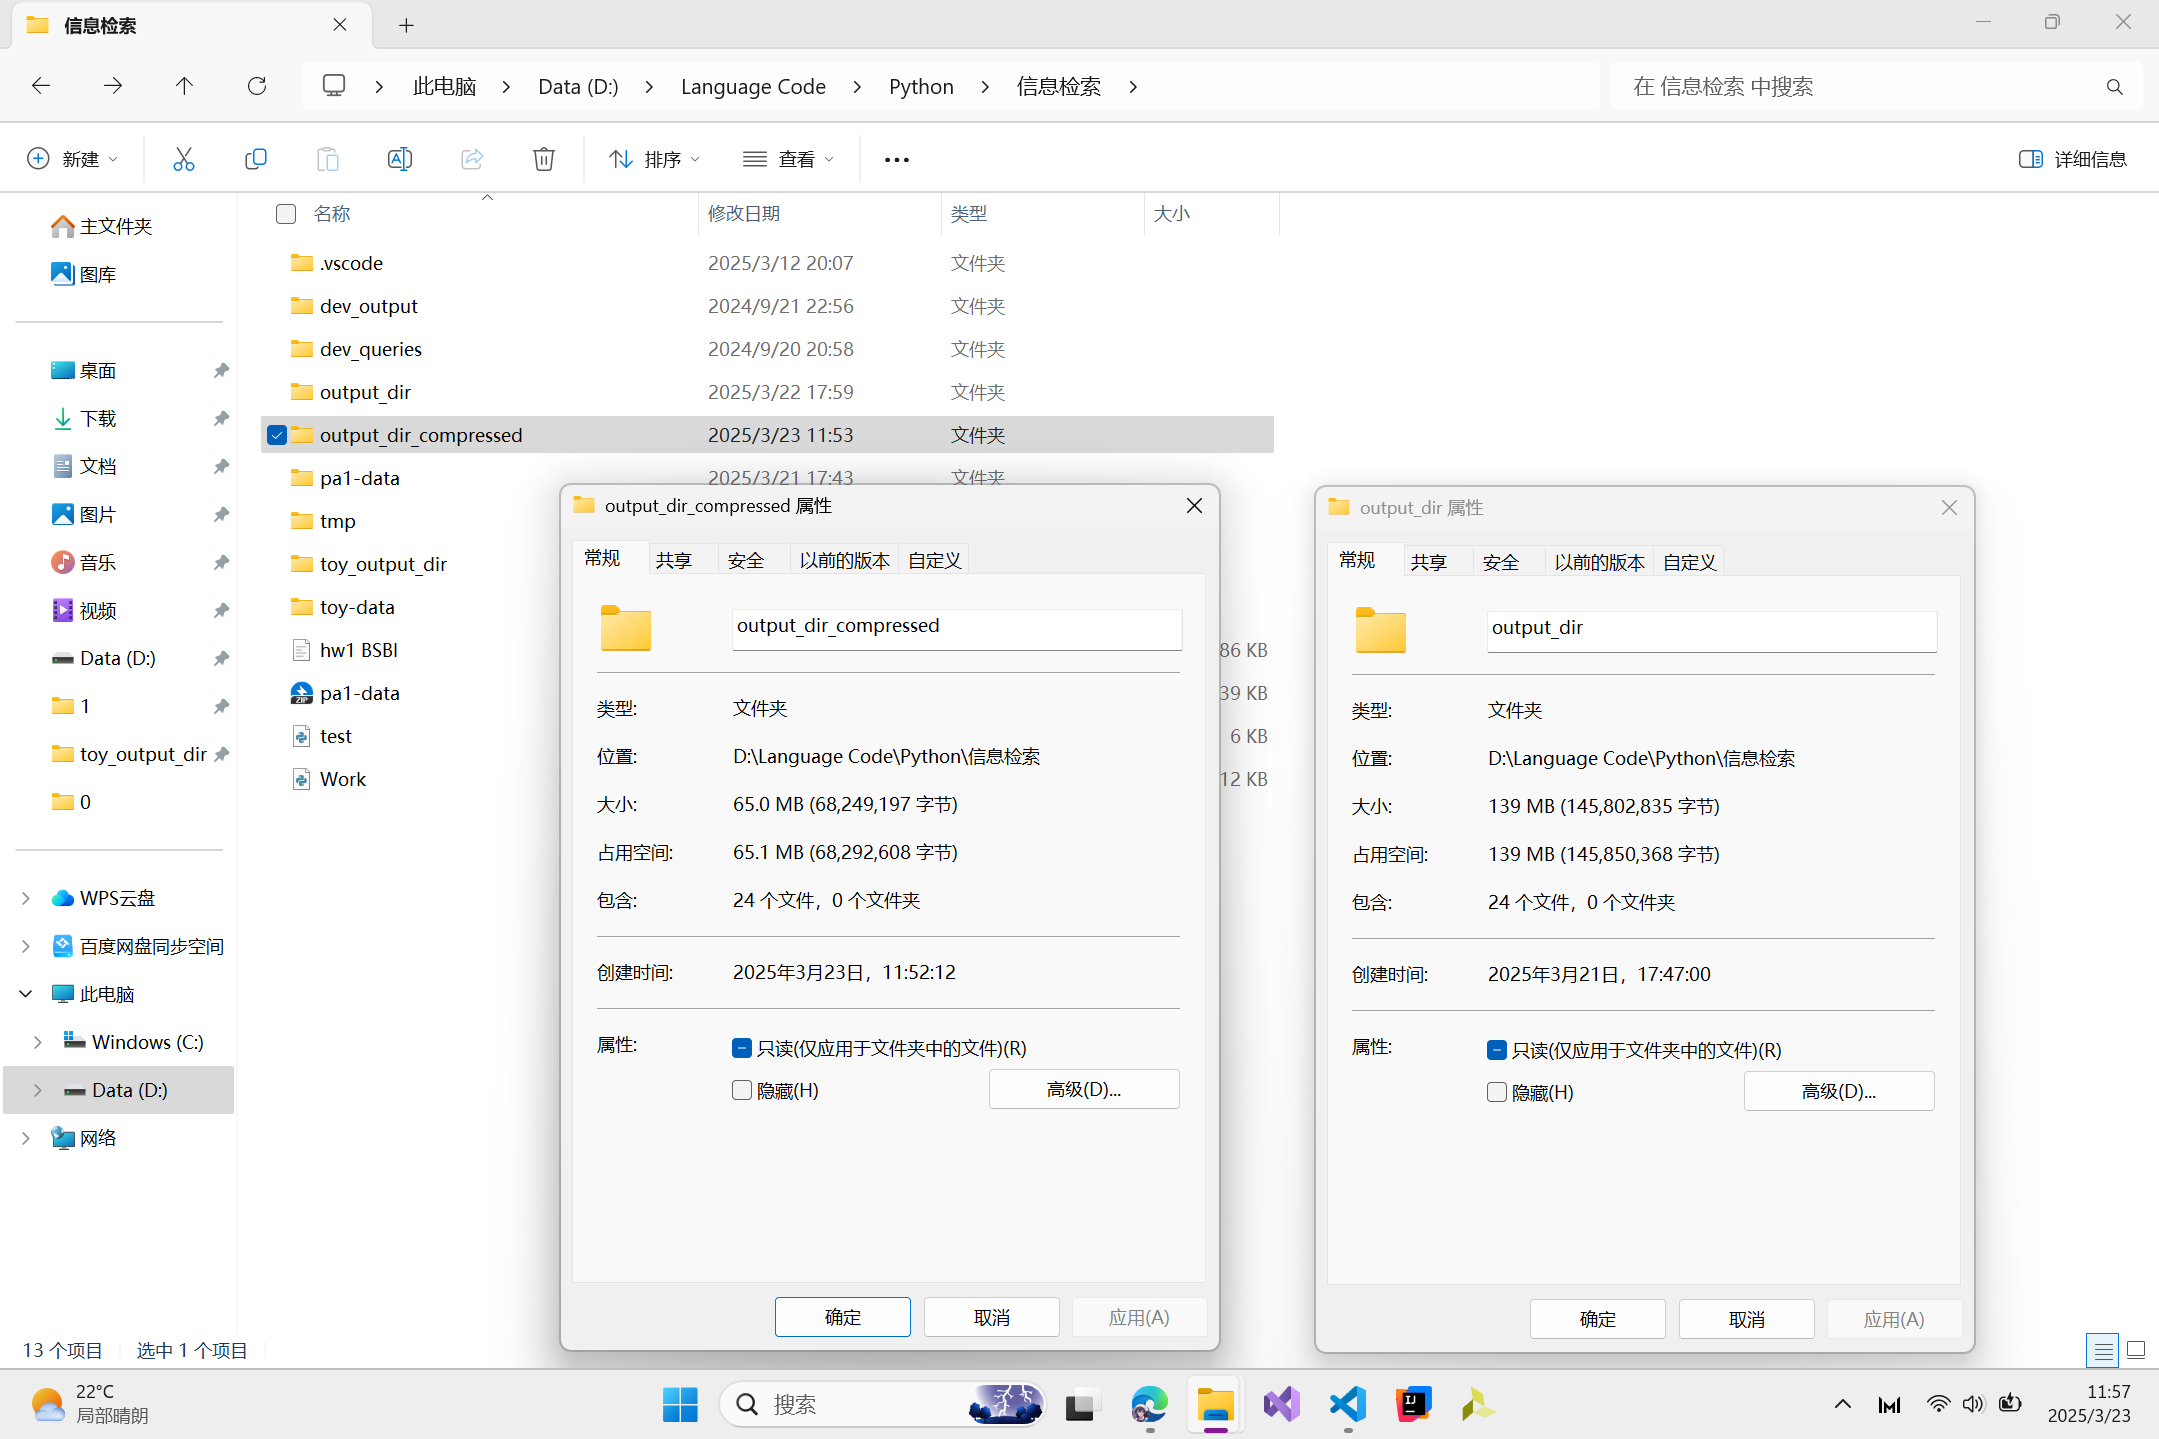

未压缩编码

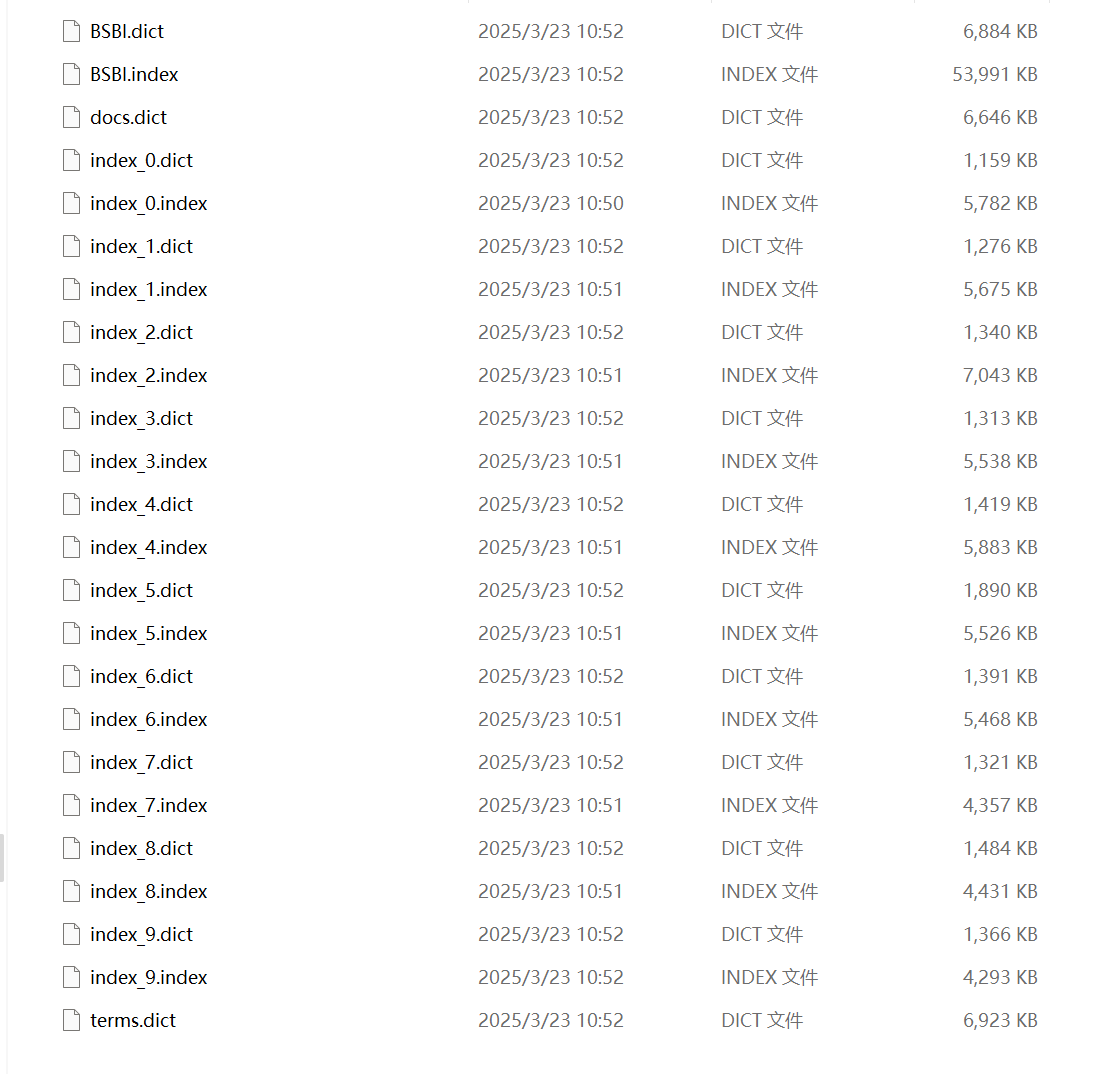

gap-encoding压缩编码

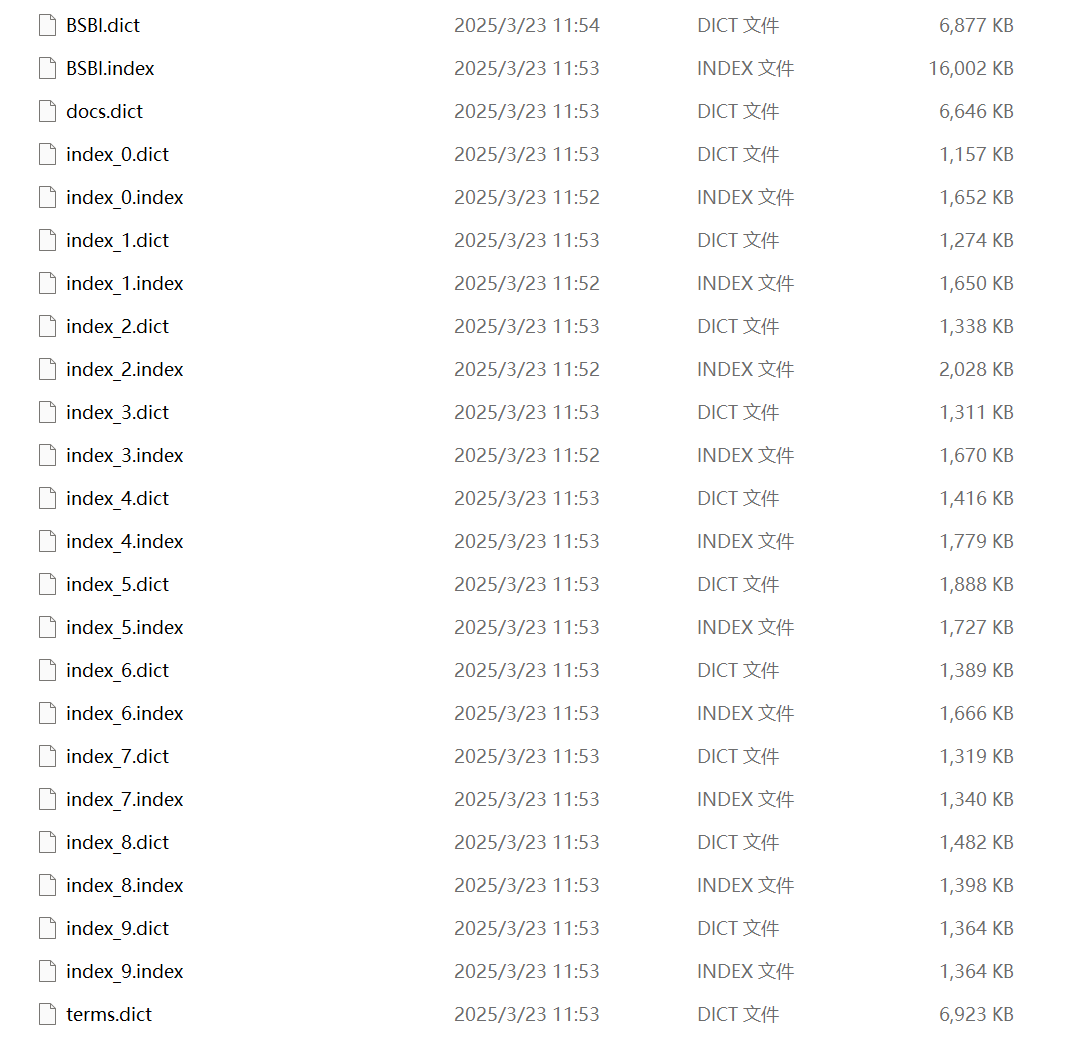

# 额外的编码方式 (10%)

# 报告

在额外编码方式中采用了gamma-encoding，它也是一种可变长编码方法，原理为：将一个数x的组成分成length和offset两部分，其中length部分用来标识x的bit位数，有几位则length部分就是几个"1"连接而成，最后加一个"0"表示结束；offset部分用来标识x的偏移量，取原本数值n位的低n-1位（因为第n位一定是1）。length和offset拼接得到编码后的二进制表示；

但是在实验过程中，在我的代码中，运行测试样例时，可以进行不经过转换为gap_list的编码解码，但是进行经过求gap后的列表来说就会错误，后通过输出编码解码后的列表比较，发现gap_list中的1在解码过程中被忽略，这是由于由于'1'的gamma编码为0，但在解码时是要记录连续的1的个数。这导致'1'被编码后，会被跳过。所以在编码时进行了修改.如果已经是填满了整字节，在最前面加‘00000000’；如果是有字节未被填满，在前面填满，并且在最开头用一个字节表示从哪一位开始查询，由于最多需要保存的数最多为7，所以一个字节就够了。在解码时，对1进行了单独的处理。

通过补充`ECCompressedPostings`的`encode` 和 `decode`方法来实现一种额外的索引压缩方式。在我们课上学的就是**gamma-encoding** 。另外如果大家感兴趣的话也可以了解**Delta Encoding** ，[ALGORITHM SIMPLE-9](https://github.com/manning/CompressionAlgorithms#simple-9) 等。

你应该以多字节（而不是bits）来存储倒排记录表，因为索引的长度和位置都存的是字节信息。 (4%)

In [48]:
class ECCompressedPostings:
    #If you need any extra helper methods you can add them here 
    ### Begin your code

    ### End your code
    
    @staticmethod
    def encode(postings_list):
        """Encodes `postings_list` 
        
        Parameters
        ----------
        postings_list: List[int]
            The postings list to be encoded
        
        Returns
        -------
        bytes: 
            Bytes reprsentation of the compressed postings list 
        """
        ### Begin your code

        if not postings_list:
            return bytes()
        
        # 计算 gap 列表
        gap_list = [postings_list[0]]
        for i in range(1, len(postings_list)):
            gap_list.append(postings_list[i] - postings_list[i - 1])


        #设置一个标志位表示第一个数是否为0,因为在文档记录中,我们使用了gap,并且进行了去重,只有可能在第一个doc_id为0.
        #在字节流前保留一位标志位表示是否为0即可解决问题。
        if(postings_list[0]==0):
            encode_str = "0"
        else:
            encode_str = "1"

        for num in gap_list:
            binary = bin(num)[2:]
            offset = len(binary) - 1
            unary = '1' * offset + '0'
            encode_str += unary + binary[1:]


        # 填充到 8 的倍数
        padding = 8 - len(encode_str) % 8
        if padding < 8:
            binary_str = bin(padding)[2:]
            # 补齐到 8 位
            binary_str = binary_str.zfill(8)[-8:]#保留从哪一位开始读取信息
            encode_str = binary_str + '0' * padding+encode_str
        
        else:
            encode_str = '0' * padding + encode_str

        byte_list = [int(encode_str[i:i + 8], 2) for i in range(0, len(encode_str), 8)]
        return bytes(byte_list)
        ### End your code

        
    @staticmethod
    def decode(encoded_postings_list):
        """Decodes a byte representation of compressed postings list
        
        Parameters
        ----------
        encoded_postings_list: bytes
            Bytes representation as produced by `CompressedPostings.encode` 
            
        Returns
        -------
        List[int]
            Decoded postings list (each posting is a docId)
        """
        ### Begin your code

        binary_str = ''.join(format(byte, '08b') for byte in encoded_postings_list)
        decode_list = []
        index = 0

        #从哪一位开始读取字符串
        post_8bits=binary_str[:8]
        t=int(post_8bits,2)
        if t>0:
            index=8+t
        else:
            index=8

        #判断第一个数是否为0
        if(binary_str[index]=='0'):
            decode_list.append(0)
            index+=2
        else:
            index+=1

        while index < len(binary_str):

            if binary_str[index]=='1':
                k = 0
                while index < len(binary_str) and binary_str[index] == '1':
                    k += 1
                    index += 1
                if index >= len(binary_str):
                    break
                index += 1  # 跳过 0
                num_binary = '1' + binary_str[index:index + k]
                num = int(num_binary, 2)
                decode_list.append(num)
                index += k
                
            #对1进行处理，因为1的gamma编码为0
            else:
                index += 1  # 跳过 0
                num_binary = '1' 
                num = int(num_binary, 2)
                decode_list.append(num)

        # 将 gap 列表转换为 postings 列表
        if not decode_list:
            return []
        postings_list = [decode_list[0]]
        for i in range(1, len(decode_list)):
            postings_list.append(postings_list[-1] + decode_list[i])
        return postings_list
      
        # return decode_list

        ### End your code

同上，写一些测试样例来确保代码正常运行 (3%)

In [49]:
### Begin your code

def test_gamma_encode_decode(l):
    e = ECCompressedPostings.encode(l)
    d = ECCompressedPostings.decode(e)
    # assert d == l
    print(l,d, e)

postings_list=[0,4,5,6,49,50,51,499,500,501,4999,5000,5001,49999,50000,50001]
e1=UncompressedPostings.encode(postings_list)
print(postings_list,e1)
test_gamma_encode_decode(postings_list)

### End your code

[0, 4, 5, 6, 49, 50, 51, 499, 500, 501, 4999, 5000, 5001, 49999, 50000, 50001] b'\x00\x00\x00\x00\x04\x00\x00\x00\x05\x00\x00\x00\x06\x00\x00\x001\x00\x00\x002\x00\x00\x003\x00\x00\x00\xf3\x01\x00\x00\xf4\x01\x00\x00\xf5\x01\x00\x00\x87\x13\x00\x00\x88\x13\x00\x00\x89\x13\x00\x00O\xc3\x00\x00P\xc3\x00\x00Q\xc3\x00\x00'
[0, 4, 5, 6, 49, 50, 51, 499, 500, 501, 4999, 5000, 5001, 49999, 50000, 50001] [0, 4, 5, 6, 49, 50, 51, 499, 500, 501, 4999, 5000, 5001, 49999, 50000, 50001] b'\x03\x06\x0f\x96\x7f\xb0\x0f\xff\x0c\x91\xff\xfc\xbf\x18'


# My notes：

初始时没有对0进行特殊的考虑，导致0会和1编码同时为‘0’，这在解码时会导致问题。又由于只有第一个doc_id可能为0，所以只需设置一个标志位对第一个1进行是否为0的判断。

编码段中添加了

`        if(postings_list[0]==0):
            encode_str = "0"
        else:
            encode_str = "1"
`
设置了标志位，表示第一个数是否为0。

解码段添加了

`        if(binary_str[index]=='0'):
            decode_list.append(0)
            index+=2
        else:
            index+=1`

解码时同样对标志位进行读取与判断情况。

这样实现了首位为0的情况的编码和解码。



In [50]:
try:
    os.mkdir('output_dir_ec')
except FileExistsError:
    pass

In [51]:
# 测试encode函数，decode函数
BSBI_instance_ec = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir_ec', postings_encoding=ECCompressedPostings)
BSBI_instance_ec.index()

In [52]:
BSBI_instance_ec = BSBIIndex(data_dir='pa1-data', output_dir = 'output_dir_ec', postings_encoding=ECCompressedPostings)
BSBI_instance_ec.retrieve('boolean retrieval')

['1\\cs276.stanford.edu_',
 '1\\cs276a.stanford.edu_',
 '3\\infolab.stanford.edu_TR_CS-TN-95-21.html',
 '4\\nlp.stanford.edu_IR-book_',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_an-appraisal-of-probabilistic-models-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_bayesian-network-approaches-to-ir-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_boolean-retrieval-2.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_computing-scores-in-a-complete-search-system-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_dictionaries-and-tolerant-retrieval-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_efficient-scoring-and-ranking-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_inexact-top-k-document-retrieval-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_probabilistic-information-retrieval-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_putting-it-all-together-1.html',
 '4\\nlp.stanford.edu_IR-book_html_htmledition_references-and-furth

请追加压缩前后的文件大小截图 (3%)

# My notes:

注意到采用gamma-encoding压缩的输出文件夹56.9MB，未采用压缩方式的输出文件夹139MB。
打开文件夹内部发现采用gamma-encoding压缩的BSBI.index文件大小为11518KB，未采用压缩方式的BSBI.index文件大小为53991KB。

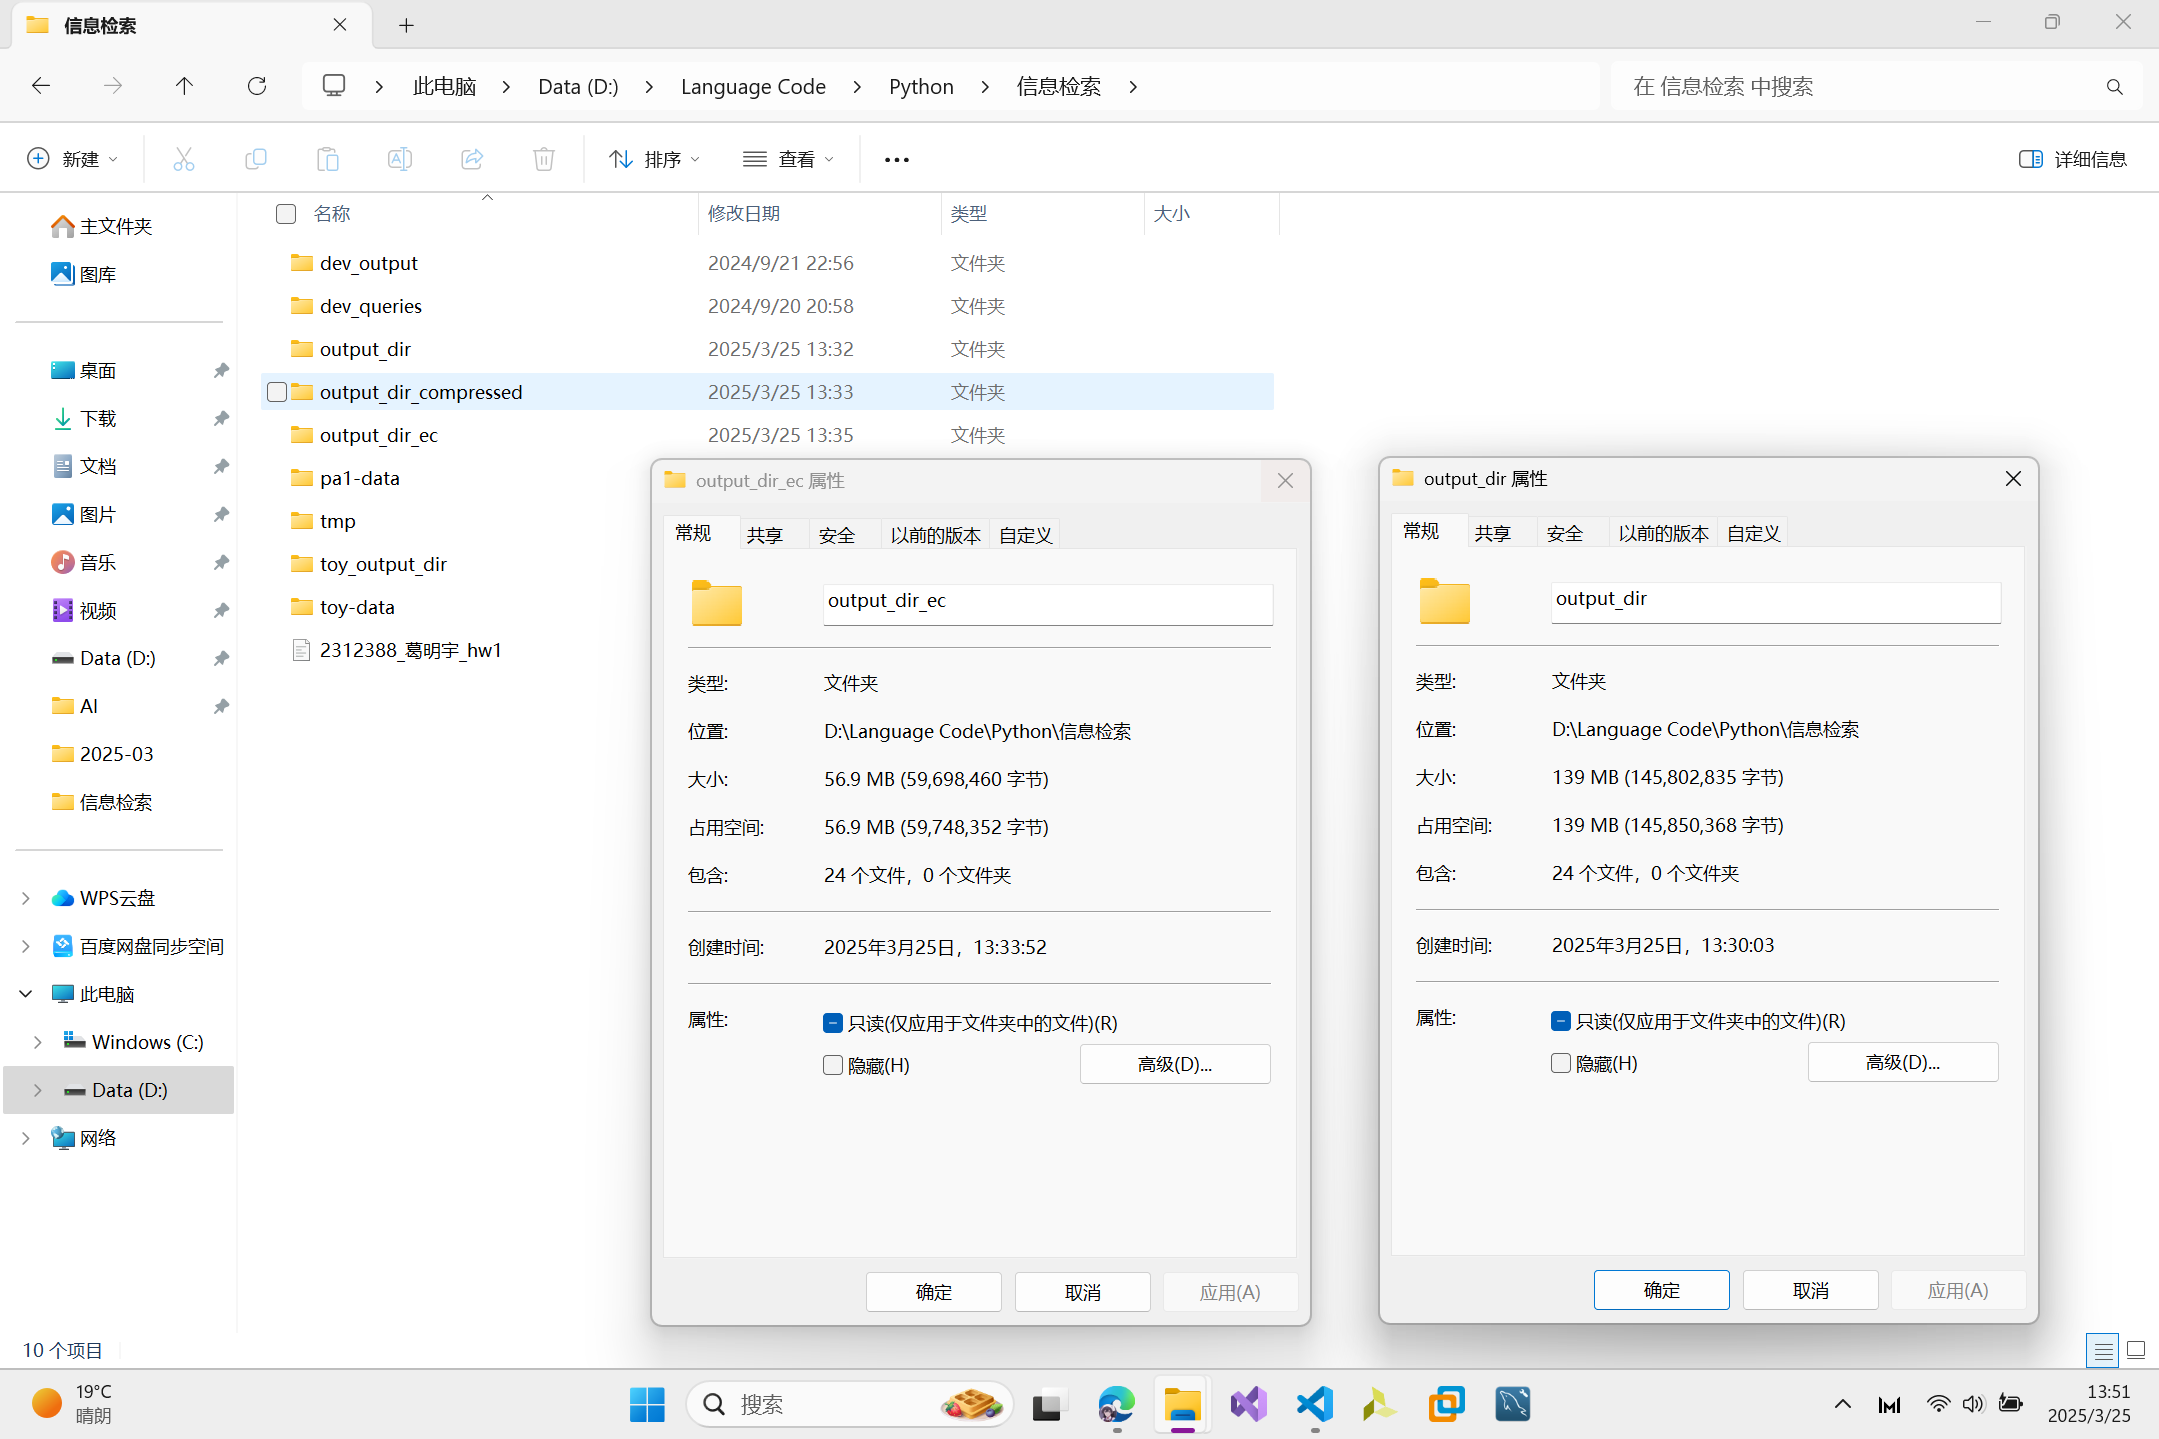
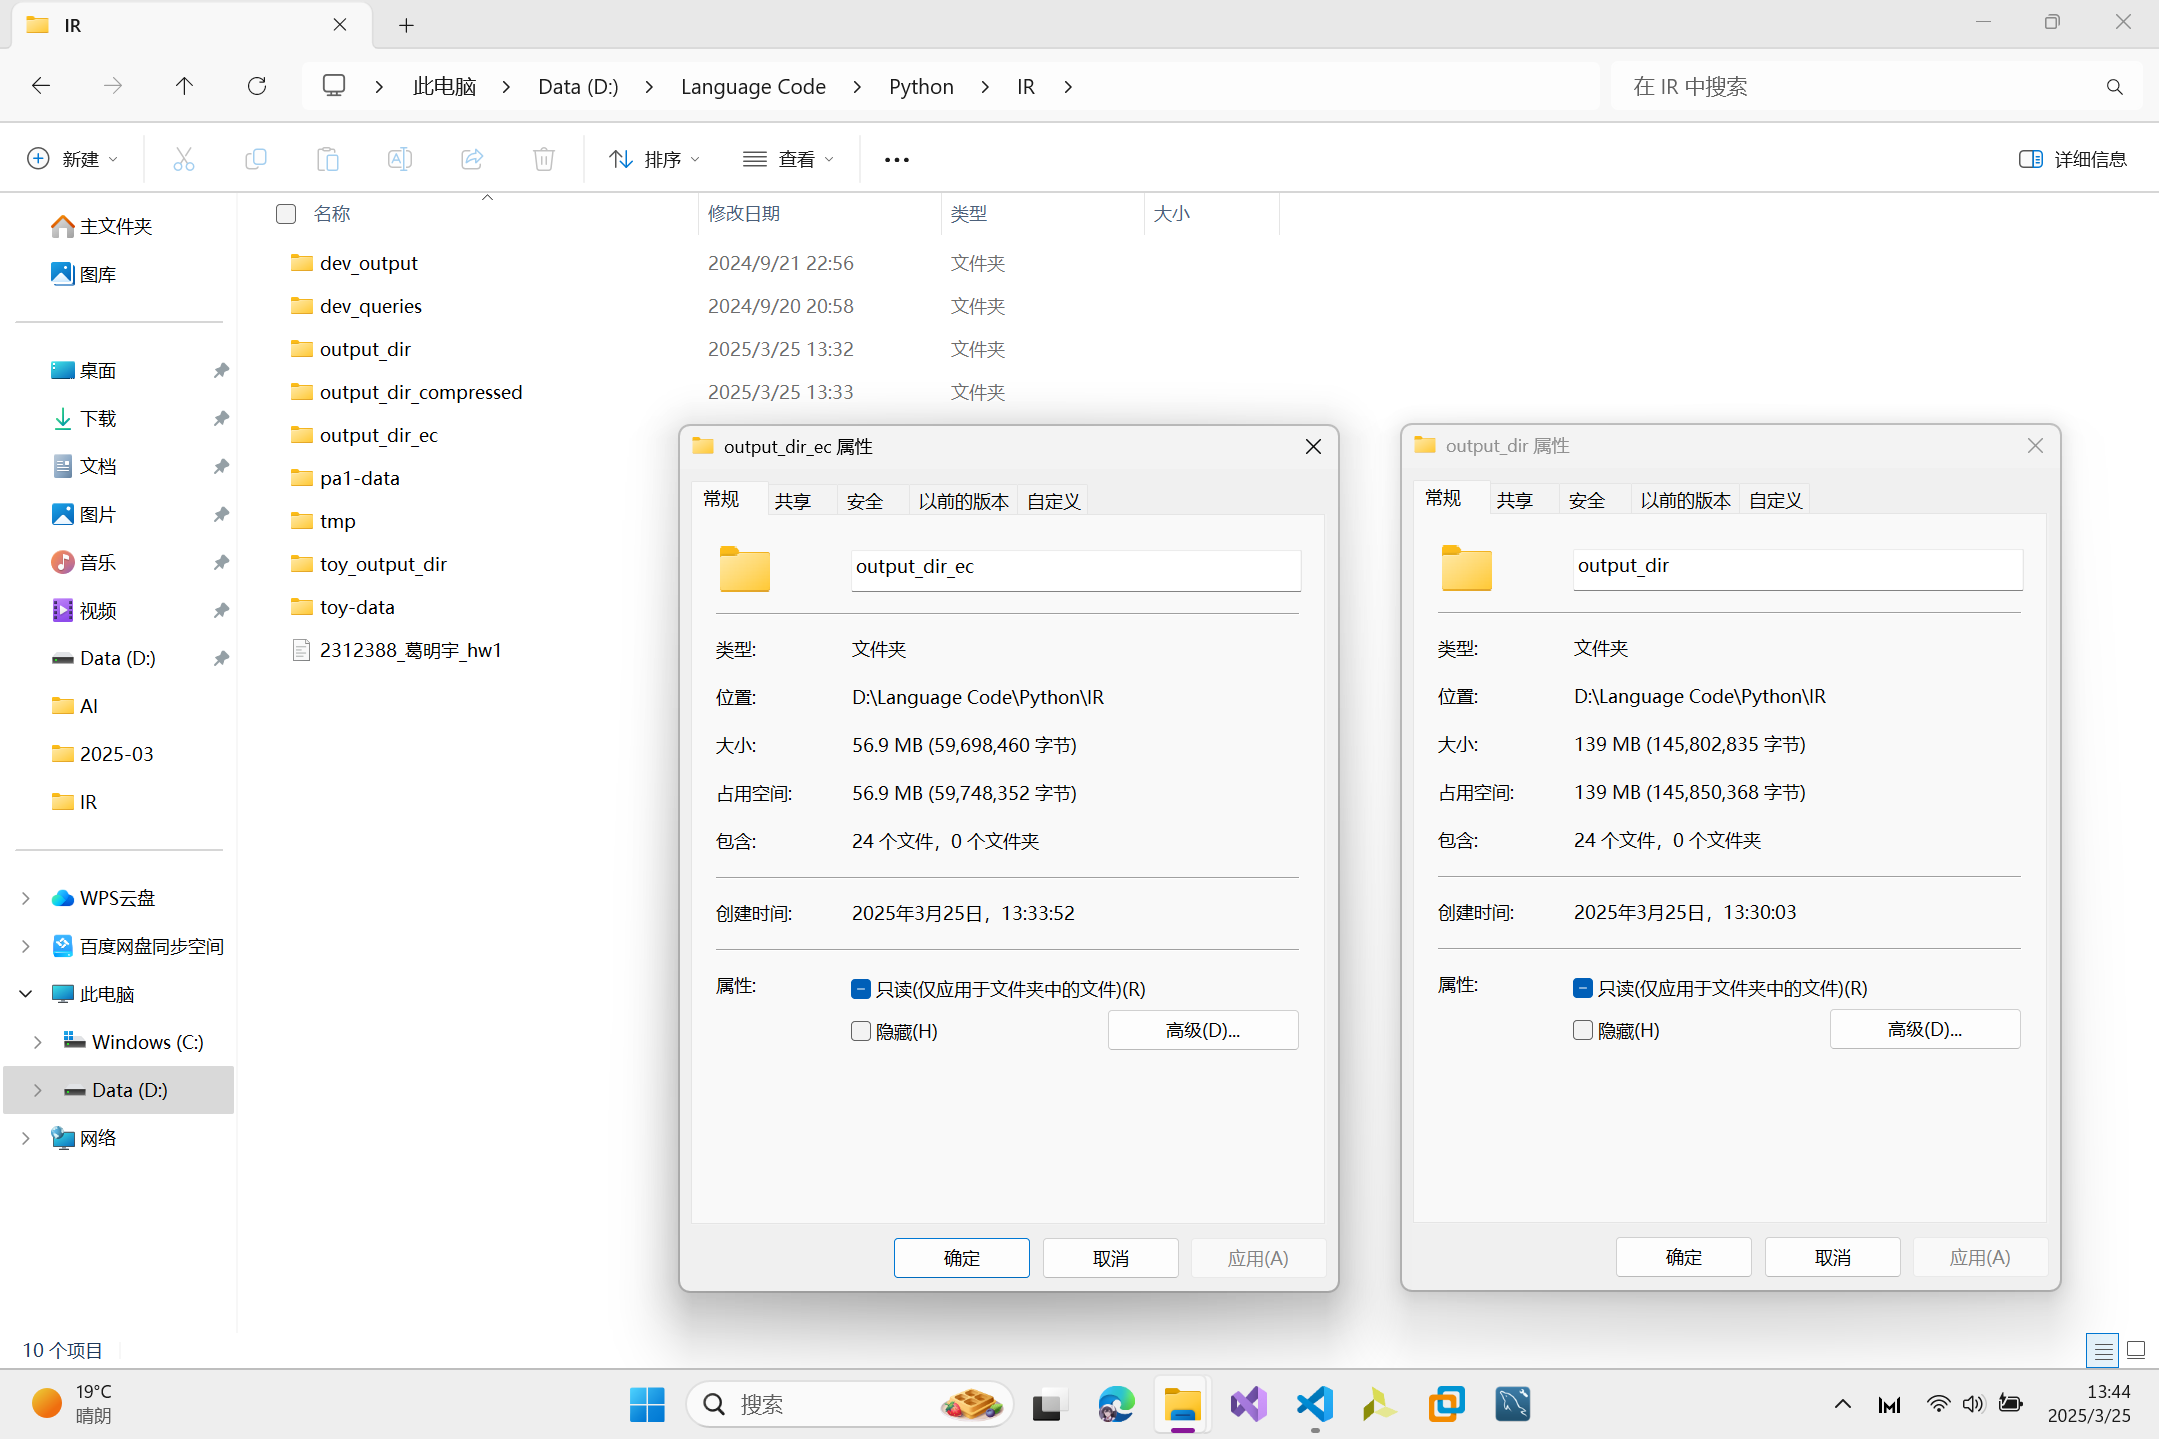
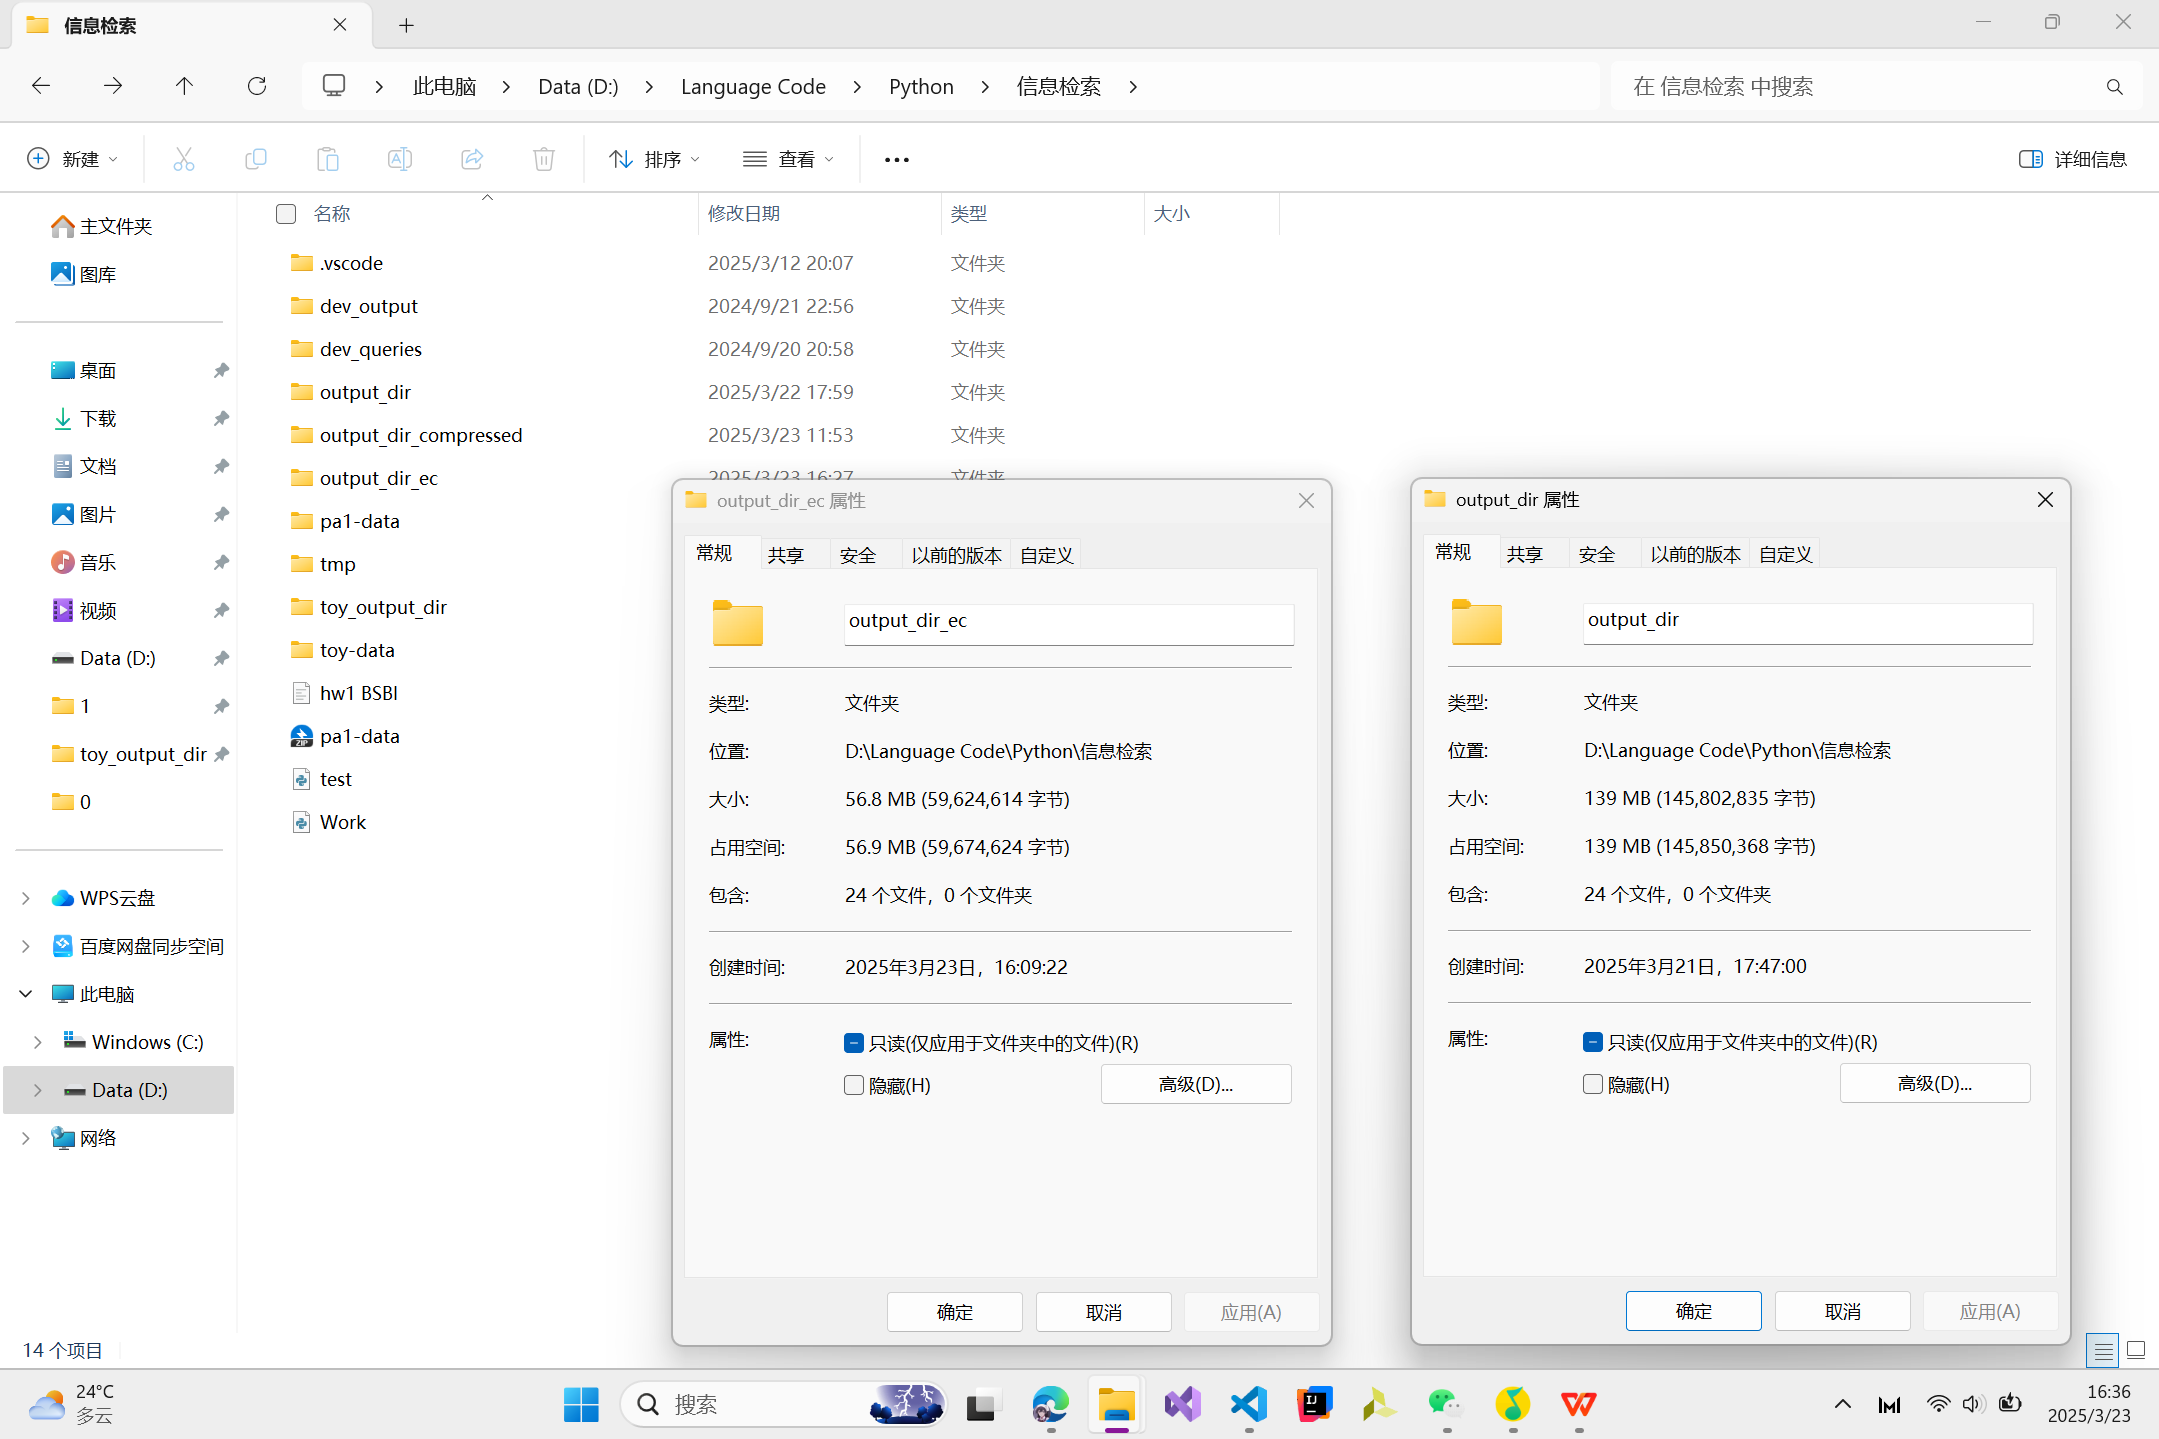

未压缩编码

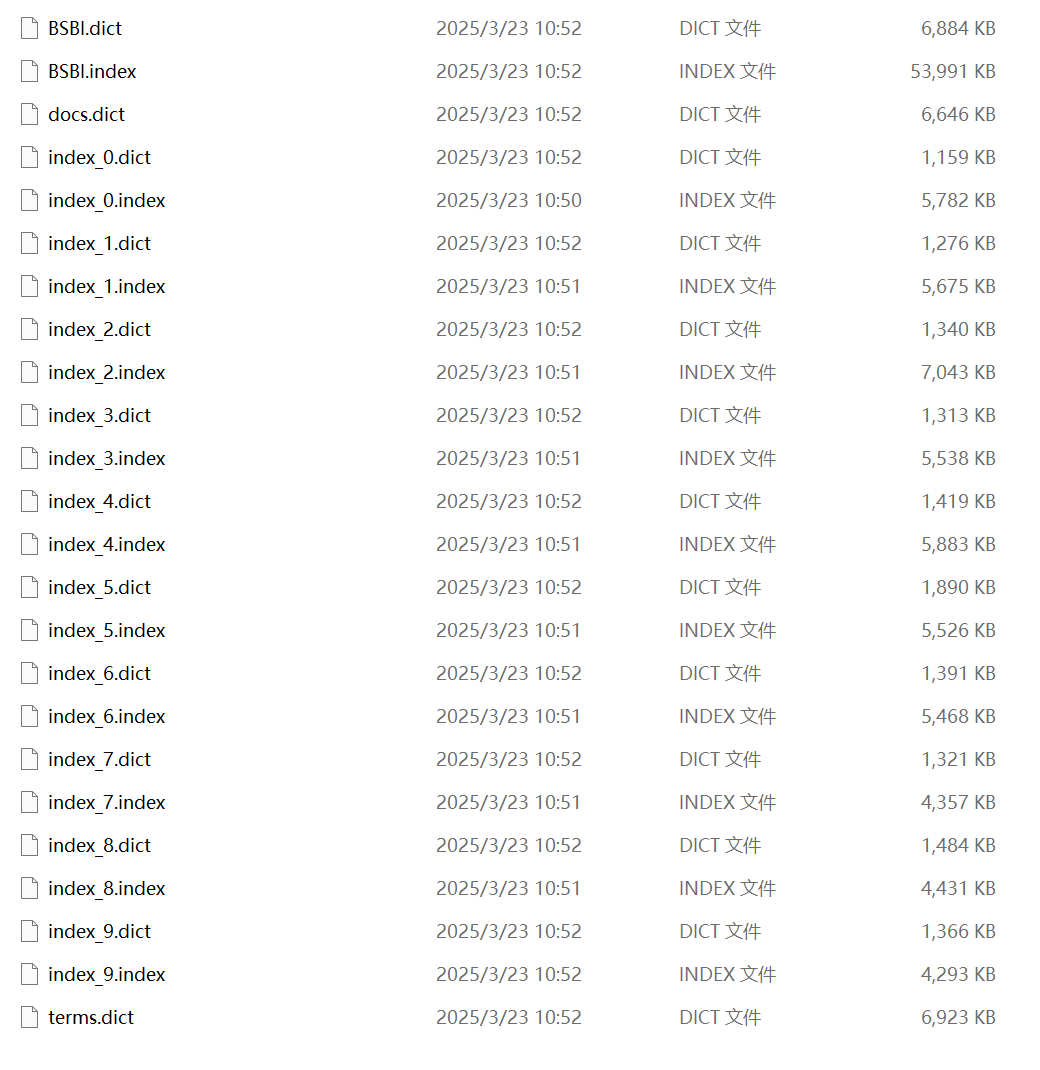

gamma-encoding压缩编码

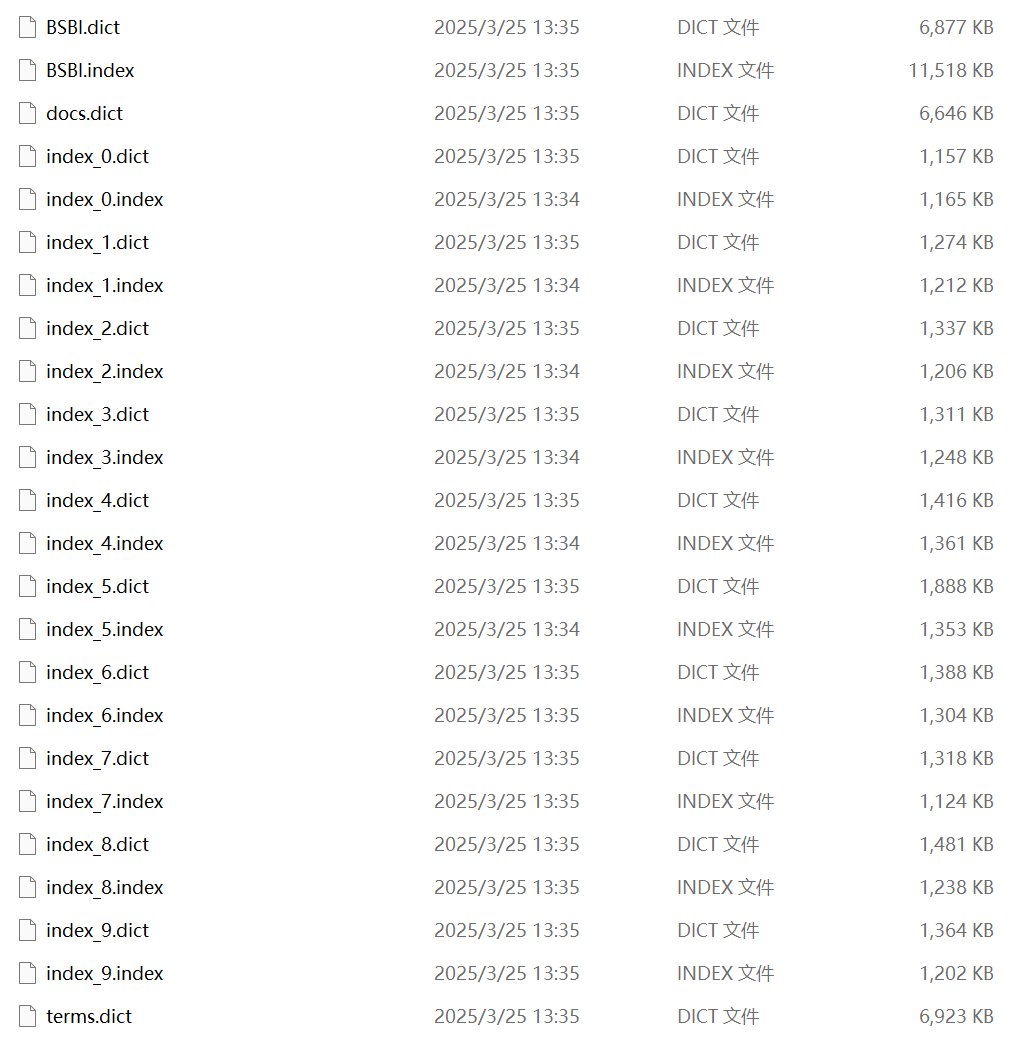

# 作业提交

本次作业用时约3周，截止日期为2025.03.26。请大家在截止日期前将代码、实验报告（可单独撰写，也可整合在jupyter notebook中）一起提交到ir24fall@163.com，邮件和文件命名方式均为`学号_姓名_hw1`，如`1811412_戚晓睿_hw1.ipynb`